# Setup

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline

import agate
import warnings
import requests
import zipfile
import io
import json

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import locale
import arrow
import xml.etree.ElementTree as ET

from locale import atof
from dateutil import parser
from datetime import datetime

plt.style.use('fivethirtyeight')
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['font.size'] = 10

warnings.filterwarnings('ignore')


/Users/deads/.virtualenvs/trump-tweet-analysis/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/deads/.virtualenvs/trump-tweet-analysis/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/deads/.virtualenvs/trump-tweet-analysis/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/deads/.virtualenvs/trump-tweet-analysis/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/deads/.virtualenvs/trump-tweet-analysis/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
/Users/deads/.virtualenvs/trump-tweet-analysis/lib/pyth

# Trump Tweet analysis

A look at Trump's tweets since inauguration day.

## Questions to answer

### Data processing

* Date grouping columns
* Sentiment analysis

### Analysis

* Frequencies sliced several ways: By day, month, hour of day
* Rates: Tweets/day, Tweets/day/month
* Retweets: What was shared heavily?
* Searches: 
  * Media organizations

# Get data

_Only run this if you need to update the Trump tweet data, for example the first time you run this script._

First, download the zipfile and unzip it in `data` directory.

**@TODO**: Cache zip files locally, read from zip into ignored local file.

In [2]:
response = requests.get('https://github.com/bpb27/trump_tweet_data_archive/raw/master/master_2017.json.zip')
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall('data')

Open the downloaded, unzipped JSON file, run sentiment analysis, remove multi-valued `entities` field, and create `data/master_2017_processed.json`.

In [3]:
with open('data/master_2017.json') as f:
    jsondata = json.load(f)

analyzer = SentimentIntensityAnalyzer()
for row in jsondata:
    del(row['entities'])
    vs = analyzer.polarity_scores(row['text'])
    row['sentiment'] = vs

with open('data/master_2017_processed.json', 'w') as f:
    json.dump(jsondata, f)

# Utilities

_Add helper functions here._

In [4]:
# Stub for helpers
# convert utc to est
def convertUTCtoFull(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('dddd, MMM D, YYYY h:mm A')

# convert to month
def convertUTCtoMonth(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('MM')

# convert to day
def convertUTCtoDay(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('D')

# convert to month/day
def convertUTCtoMonthDay(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('YYYY-MM-DD')

# convert to day of week
def convertUTCtoDayOfWeek(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('d')

# convert to time
def convertUTCtoHourOfDay(date):
    utc = arrow.get(date)
    return int(utc.to('US/Eastern').format('HH'))

# convert to week of year
def convertUTCtoWeekNumber(date):
    return int(date.strftime('%U'))

# Strip HTML
def stripHTML(html):
    tree = ET.fromstring(html)
    return ET.tostring(tree, encoding='utf8', method='text')

# Data processing

Open the `json` file and then use the `json_normalize()` function to flatten it for use with Pandas, which doesn't like nested json.

In [5]:
with open('data/master_2017_processed.json') as f:
    jsondata = json.load(f)
normalized_json = pd.io.json.json_normalize(jsondata)
tweets = pd.DataFrame(normalized_json)
tweets['created_date'] = pd.to_datetime(tweets['created_at'])

Add many time grouping columns.

In [6]:
tweets['human_date'] = tweets['created_date'].apply(convertUTCtoFull)
tweets['month/day'] = tweets['created_date'].apply(convertUTCtoMonthDay)
tweets['month'] = tweets['created_date'].apply(convertUTCtoMonth)
tweets['day'] = tweets['created_date'].apply(convertUTCtoDay)
tweets['day of week'] = tweets['created_date'].apply(convertUTCtoDayOfWeek)
tweets['hour'] = tweets['created_date'].apply(convertUTCtoHourOfDay)
tweets['week'] = tweets['created_date'].apply(convertUTCtoWeekNumber)
tweets.set_index('created_date', inplace=True)

# Sources

In [7]:
tweets['source_clean'] = tweets['source'].apply(stripHTML)
tweets['source_clean'].unique()

array([b'Twitter for iPhone', b'Twitter Ads', b'Media Studio',
       b'Twitter for Android', b'Twitter Web Client'], dtype=object)

# Frequencies

## Total Tweets

In [8]:
len(tweets.index)

711

## Tweets per hour

Trump loves the morning hours, especially the 8am-9am range.

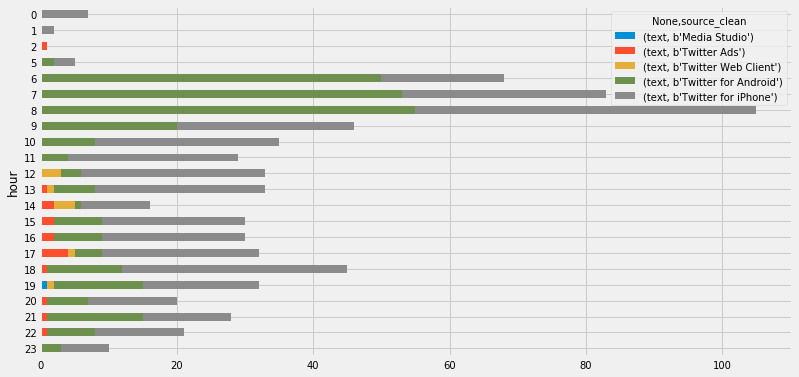

In [9]:
tweetsPerHour = tweets[['source_clean', 'hour', 'text']].pivot_table(
    index='hour', columns=['source_clean'], aggfunc='count')
tweetsPerHour.to_csv('output/tweets-per-hour-of-day.csv')
tweetsPerHour.iloc[::-1].plot(kind='barh', stacked=True)

## Tweets per day

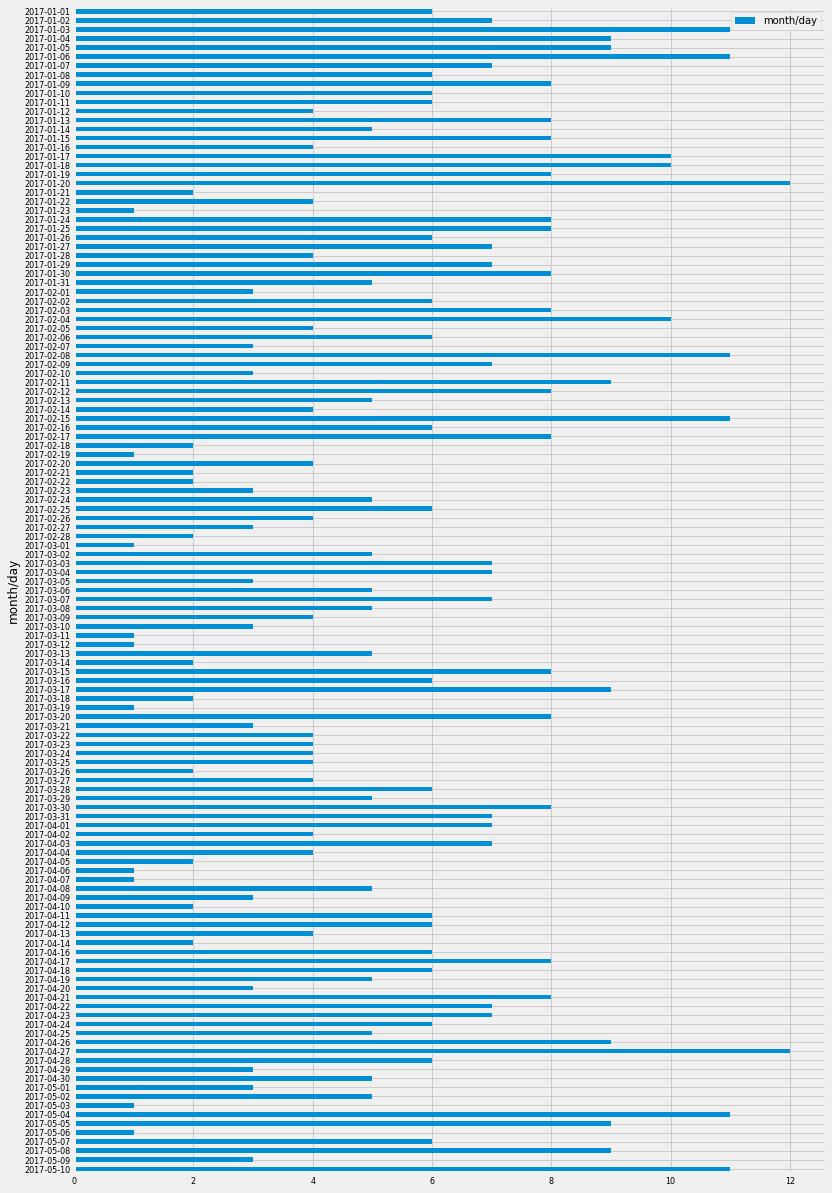

In [10]:
tweetsPerDay = tweets[['month/day']].groupby(tweets['month/day']).count()
tweetsPerDay.iloc[::-1].plot(kind='barh', figsize=(12,20), fontsize=8)

In [11]:
tweetsPerDay.describe()

,month/day
count,129.000000
mean,5.511628
std,2.795410
min,1.000000
25%,3.000000
50%,5.000000
75%,8.000000
max,12.000000


## Tweets per day of week

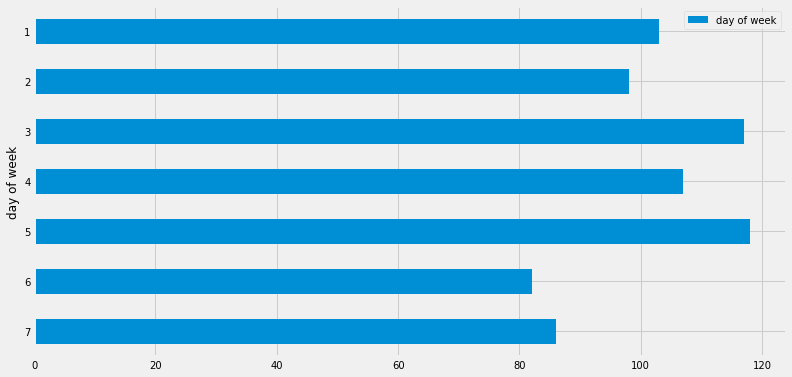

In [12]:
tweetsPerDayOfWeek = tweets[['day of week']].groupby(tweets['day of week']).count()
tweetsPerDayOfWeek.iloc[::-1].plot(kind='barh')

## Tweets per month

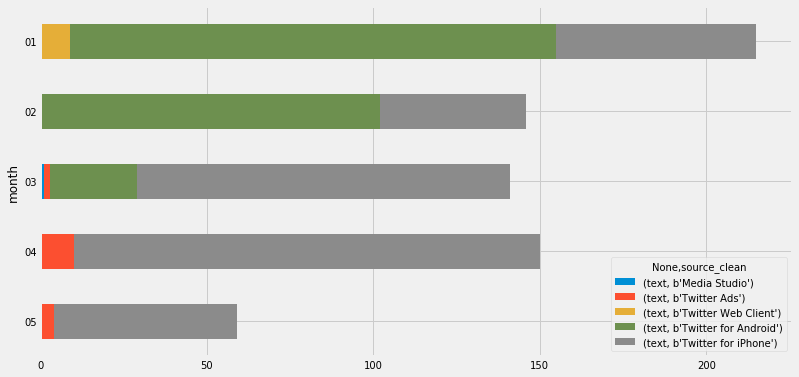

In [13]:
tweetsPerMonth = tweets[['source_clean', 'month', 'text']].pivot_table(index='month', columns=['source_clean'], aggfunc='count')
tweetsPerMonth.iloc[::-1].plot(kind='barh', stacked=True)

## Tweets per week

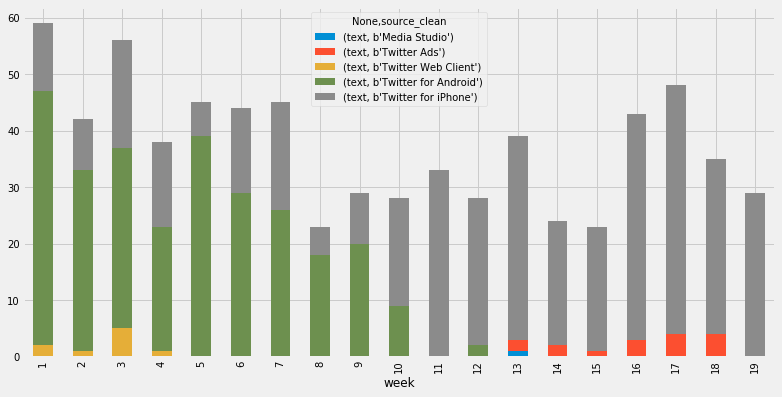

In [14]:
tweetsPerWeek = tweets[['source_clean', 'week', 'text']].pivot_table(index='week', columns=['source_clean'], aggfunc='count')
tweetsPerWeek.to_csv('output/tweetsperweek-by-device.csv', na_rep=0)
tweetsPerWeek.plot(kind='bar', stacked=True)

# Sentiment

We see a significant increase in Trump's "positivity" as measured by VADER (the same algorithm that is used by BOTUS).

_Jupyter is both amazin and stupid... this disabled scrolling to let me loop over plotting._


In [15]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [16]:
sentiment_fields = ['sentiment.compound'] #, 'sentiment.pos', 'sentiment.neg', 'sentiment.neu']

In [17]:
pd.set_option('display.width', 1000)
tweets.sort(columns='sentiment.compound')[['sentiment.compound', 'text']].head()

,sentiment.compound,text
created_date,,
2017-04-18 10:38:59,-0.9735,Democrat Jon Ossoff would be a disaster in Con...
2017-02-07 12:11:29,-0.9370,"I don't know Putin, have no deals in Russia, a..."
2017-01-15 22:46:33,-0.9354,.@NBCNews is bad but Saturday Night Live is th...
2017-02-04 21:44:49,-0.9307,"Because the ban was lifted by a judge, many ve..."
2017-04-09 15:20:39,-0.9245,So sad to hear of the terrorist attack in Egyp...


In [18]:
tweets.sort(columns='sentiment.compound', ascending=False)[['sentiment.compound', 'text']].head()

,sentiment.compound,text
created_date,,
2017-01-01 06:49:49,0.9765,RT @IvankaTrump: 2016 has been one of the most...
2017-01-22 12:35:09,0.9679,Had a great meeting at CIA Headquarters yester...
2017-02-02 11:25:40,0.9674,Attending Chief Ryan Owens' Dignified Transfer...
2017-02-01 03:45:26,0.9666,Hope you like my nomination of Judge Neil Gors...
2017-01-09 11:17:40,0.9600,Rupert Murdoch is a great guy who likes me muc...


In [19]:
tweets.sort(columns=['week', 'sentiment.compound'], ascending=False)[['week', 'sentiment.compound', 'text']].head(40)

,week,sentiment.compound,text
created_date,,,
2017-05-08 11:32:24,19,0.9508,Congratulations to @PGA_JohnDaly on his big wi...
2017-05-09 17:19:16,19,0.9041,It was an honor to welcome the Teachers of the...
2017-05-07 19:22:17,19,0.8398,Congratulations to Emmanuel Macron on his big ...
2017-05-10 12:30:51,19,0.8074,"years, as a pol in Connecticut, Blumenthal wou..."
2017-05-08 17:42:32,19,0.7783,"Honored to welcome Georgia Prime Minister, Gio..."
2017-05-10 11:21:02,19,0.6166,RT @DRUDGE_REPORT: MEXICO 2ND DEADLIEST COUNTR...
2017-05-10 11:19:04,19,0.5574,James Comey will be replaced by someone who wi...
2017-05-10 11:27:13,19,0.5562,Comey lost the confidence of almost everyone i...
2017-05-10 12:24:32,19,0.4767,Watching Senator Richard Blumenthal speak of C...


## By month

### Average

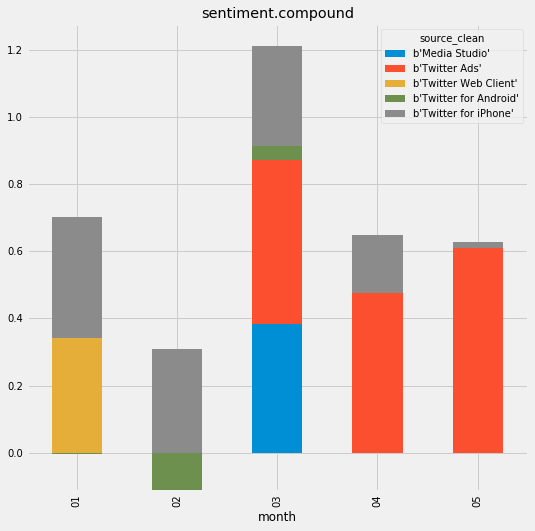

In [20]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source_clean', 'month', field]].pivot_table(index='month', columns='source_clean', values=field, aggfunc='mean')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field, figsize=(8,8))

### Cumulative

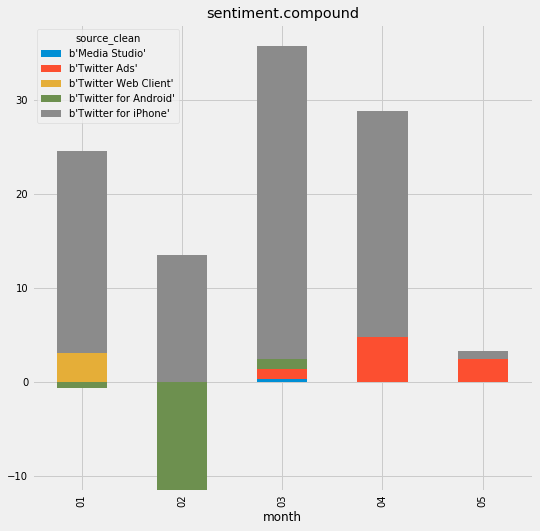

In [21]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source_clean', 'month', field]].pivot_table(index='month', columns='source_clean', values=field, aggfunc='sum')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field, figsize=(8,8))

## By week

### Average

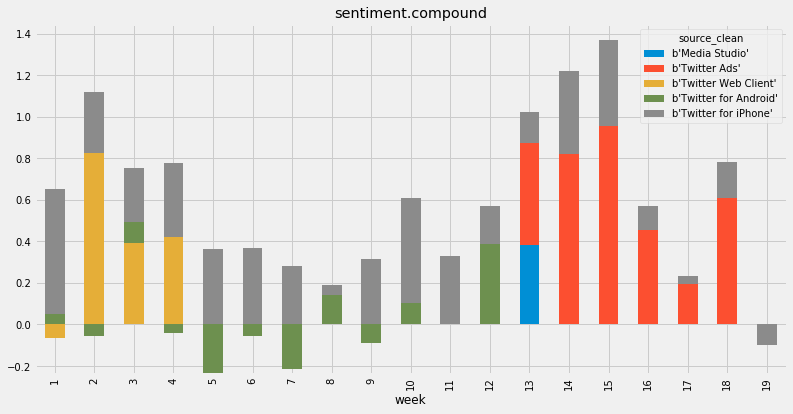

In [22]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source_clean', 'week', field]].pivot_table(index='week', columns='source_clean', values=field, aggfunc='mean')
    sentimentByMonth.to_csv('output/sentiment-by-week-by-device.csv')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field)

### Cumulative

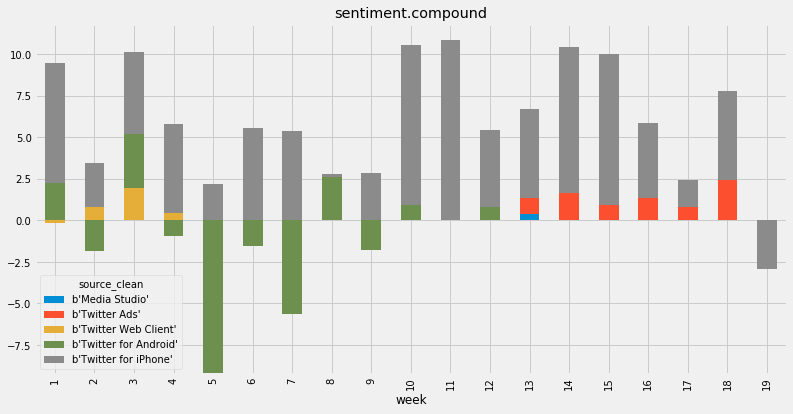

In [23]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['source_clean', 'week', field]].pivot_table(index='week', columns='source_clean', values=field, aggfunc='sum')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field)

### Average, not broken down by device

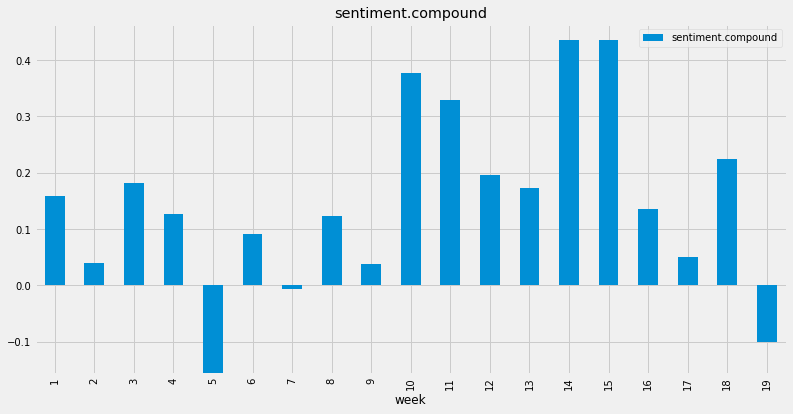

In [24]:
for field in sentiment_fields:    
    sentimentByMonth = tweets[['week', field]].groupby('week').mean()
    sentimentByMonth.to_csv('output/sentiment-by-week.csv')
    sentimentByMonth.plot(kind='bar', stacked=True, title=field)

## Every Tweet's sentiment analysis

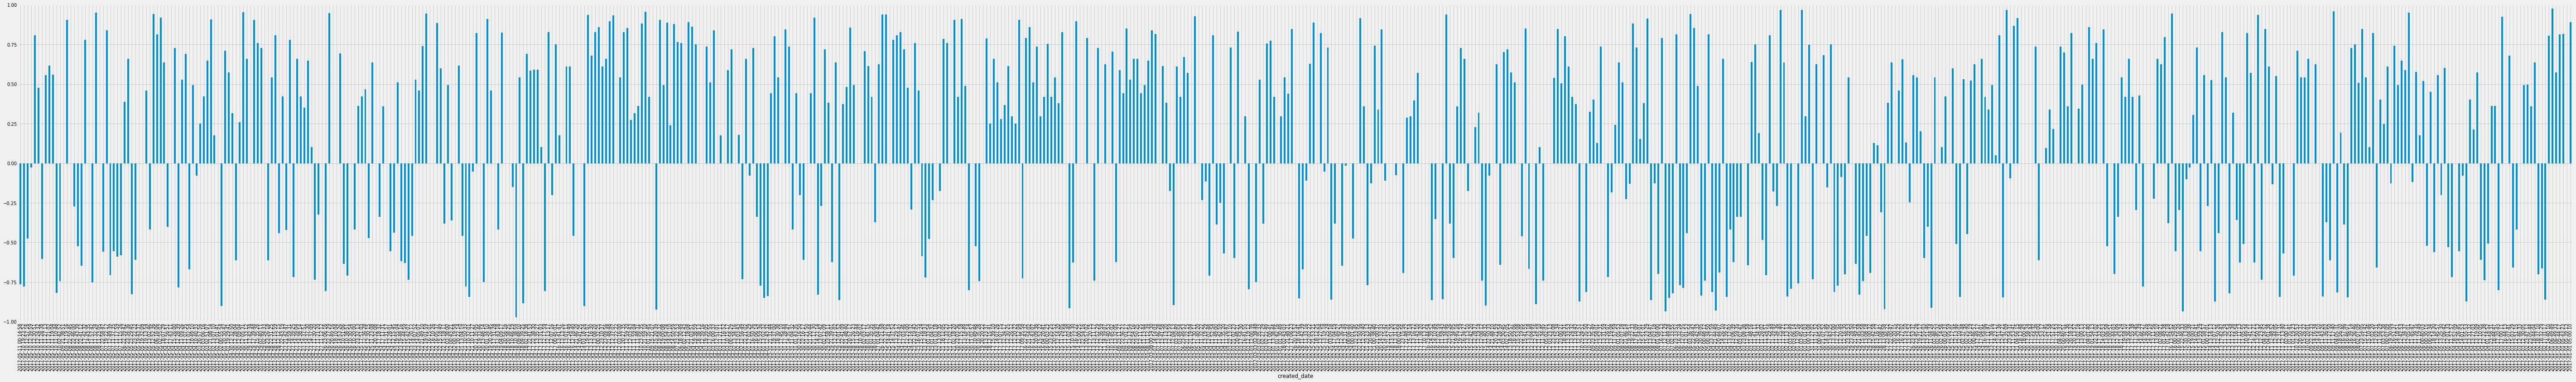

In [25]:
tweets['sentiment.compound'].plot(kind='bar', ylim=[-1,1], figsize=(90,12))

# Follower count

The strange drops in follower count are interesting here. The follower ceiling is strangely lacking in noise.

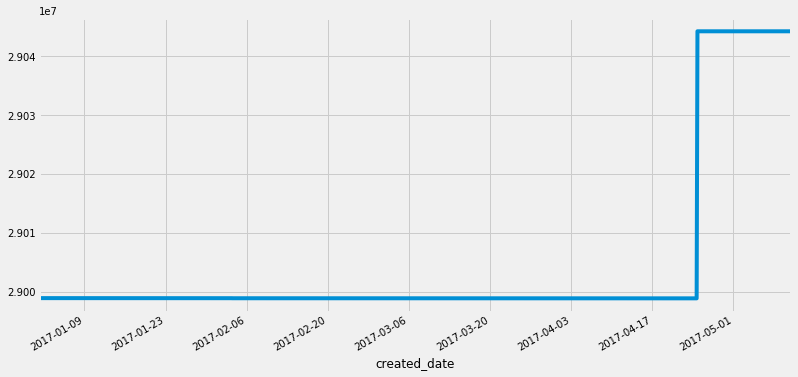

In [26]:
tweets['user.followers_count'].plot()

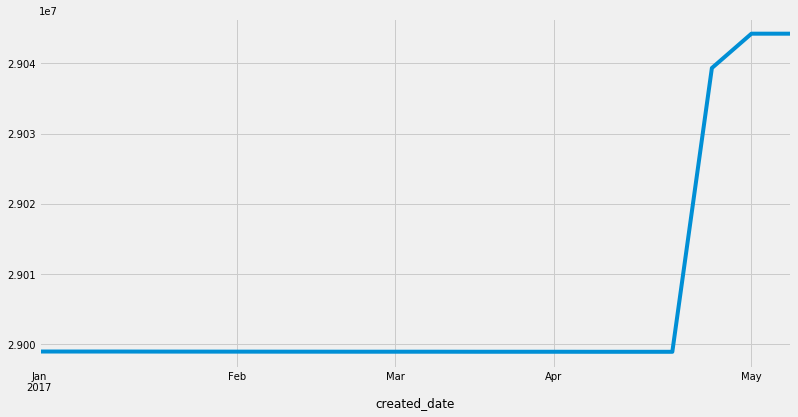

In [27]:
tweets['user.followers_count'].resample('W').plot()

# Per tweet sentiment

In [28]:
sortedSentimentPerTweet = tweets[['week', 'sentiment.compound', 'text', 'id']].sort(['week', 'sentiment.compound'], ascending=False)
sortedSentimentPerTweet.to_csv('output/sentiment-per-tweet.csv')
sortedSentimentPerTweet

,week,sentiment.compound,text,id
created_date,,,,
2017-05-08 11:32:24,19,0.9508,Congratulations to @PGA_JohnDaly on his big wi...,861544307043467264
2017-05-09 17:19:16,19,0.9041,It was an honor to welcome the Teachers of the...,861993986436866049
2017-05-07 19:22:17,19,0.8398,Congratulations to Emmanuel Macron on his big ...,861300169438113793
2017-05-10 12:30:51,19,0.8074,"years, as a pol in Connecticut, Blumenthal wou...",862283792559616000
2017-05-08 17:42:32,19,0.7783,"Honored to welcome Georgia Prime Minister, Gio...",861637456281690113
2017-05-10 11:21:02,19,0.6166,RT @DRUDGE_REPORT: MEXICO 2ND DEADLIEST COUNTR...,862266225157689349
2017-05-10 11:19:04,19,0.5574,James Comey will be replaced by someone who wi...,862265729718128641
2017-05-10 11:27:13,19,0.5562,Comey lost the confidence of almost everyone i...,862267781336752128
2017-05-10 12:24:32,19,0.4767,Watching Senator Richard Blumenthal speak of C...,862282202188566529


# Text analysis

Common words.

In [29]:
from collections import Counter
import nltk
import string
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/deads/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
top_N = 100
stopwords = nltk.corpus.stopwords.words('english')
stopwords = stopwords + ['rt']
# RegEx for stopwords
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
# replace '|'-->' ' and drop all stopwords
words = (tweets.text
           .str.lower()
           .replace([r'\|', RE_stopwords], [' ', ''], regex=True)
           .str.cat(sep=' ')
           .split()
)

# generate DF out of Counter
words_data = pd.DataFrame(Counter(words).most_common(300),
                    columns=['Word', 'Frequency']).set_index('Word')

pd.set_option('display.max_rows', top_N)
words_data.to_csv('output/word-frequencies.csv')
words_data.head(top_N)
#pd.reset_option('display.max_rows')

# plot
# rslt.plot.bar(rot=0, figsize=(16,10), width=0.8)

,Frequency
Word,
great,111
&amp;,96
',62
-,62
fake,55
!,54
big,52
.,49
u..,41


# Specific text searches

In [31]:
from IPython.display import display, Markdown
def analyzeText(search):
    display(Markdown('## Search: _{0}_'.format(search)))
    filtered = tweets[tweets['text'].str.contains(search, case=False)]
    count = len(filtered)
    percent = float(len(filtered))/len(tweets) * 100
    display(Markdown('Number of Tweets: {0}'.format(count)))
    display(Markdown('Percent of all Tweets: {0:.2f}%'.format(percent)))
    analyzedByWeek = filtered[['source_clean', 'week', 'text']].pivot_table(index='week', columns='source_clean', aggfunc='count')
    analyzedByWeek = analyzedByWeek.reindex(range(tweets['week'].min(), tweets['week'].max())).fillna(0)
    analyzedByWeek.to_csv('output/word-by-week-{0}.csv'.format(search))
    analyzedByWeekPlot = analyzedByWeek.plot(kind='bar', stacked=True, title='{0} by week'.format(search)) 
    plt.show()
    analyzedByHour = filtered[['source_clean', 'hour', 'text']].pivot_table(index='hour', columns='source_clean', aggfunc='count')
    analyzedByHour = analyzedByHour.reindex(range(0, 24)).fillna(0)
    analyzedByHour.to_csv('output/word-by-hour-{0}.csv'.format(search))
    analyzedByHourPlot = analyzedByHour.plot(kind='bar', stacked=True, title='{0} by hour of day'.format(search))
    plt.show()
    display(Markdown('### The Tweets'))
    for i, row in filtered.iterrows():
        display(Markdown('[{0}](https://twitter.com/realDonaldTrump/status/{2}): {1}'.format(row['human_date'], row['text'], row['id'])))
    display(Markdown('---'))

## Search: _great_

Number of Tweets: 116

Percent of all Tweets: 16.32%

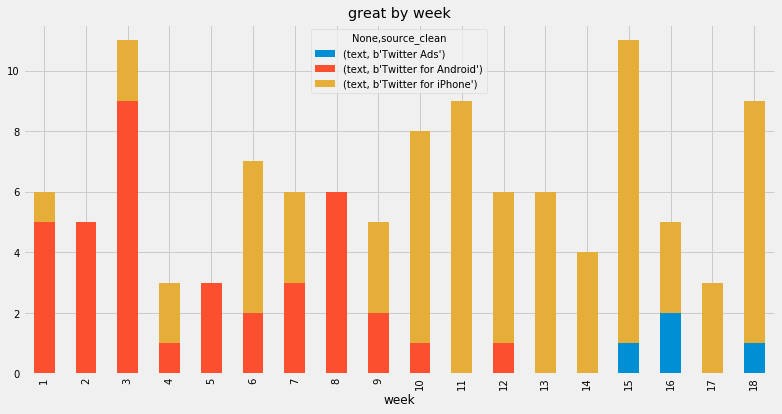

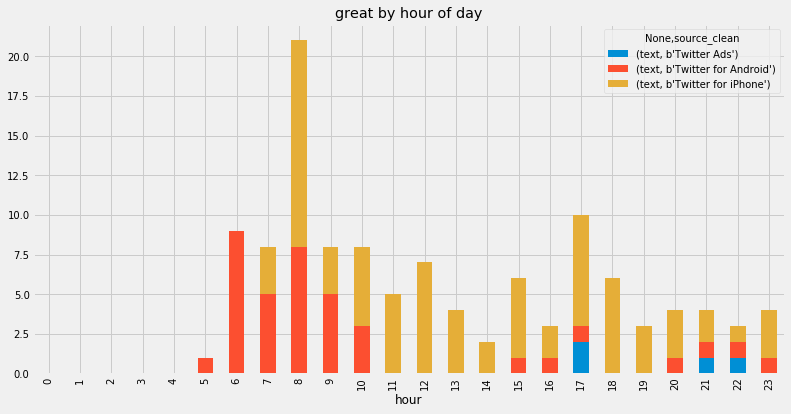

### The Tweets

[Wednesday, May 10, 2017 8:30 AM](https://twitter.com/realDonaldTrump/status/862283792559616000): years, as a pol in Connecticut, Blumenthal would talk of his great bravery and conquests in Vietnam - except he was never there. When....

[Wednesday, May 10, 2017 8:24 AM](https://twitter.com/realDonaldTrump/status/862282202188566529): Watching Senator Richard Blumenthal speak of Comey is a joke. "Richie" devised one of the greatest military frauds in U.S. history. For....

[Monday, May 8, 2017 7:32 AM](https://twitter.com/realDonaldTrump/status/861544307043467264): Congratulations to @PGA_JohnDaly on his big win yesterday. John is a great guy who never gave up - and now a winner again!

[Friday, May 5, 2017 7:34 PM](https://twitter.com/realDonaldTrump/status/860638890570416132): Great jobs report today - It is all beginning to work!

[Friday, May 5, 2017 3:13 PM](https://twitter.com/realDonaldTrump/status/860573284462669824): Of course the Australians have better healthcare than we do --everybody does. ObamaCare is dead! But our healthcare will soon be great.

[Friday, May 5, 2017 8:52 AM](https://twitter.com/realDonaldTrump/status/860477328882905089): Big win in the House - very exciting! But when everything comes together with the inclusion of Phase 2, we will have truly great healthcare!

[Thursday, May 4, 2017 10:55 PM](https://twitter.com/realDonaldTrump/status/860326946147840001): It was a GREAT day for the United States of America! This is a great plan that is a repeal &amp; replace of ObamaCare.… https://t.co/0TnmLn55Lm

[Thursday, May 4, 2017 1:56 PM](https://twitter.com/realDonaldTrump/status/860191508619722752): Insurance companies are fleeing ObamaCare - it is dead. Our healthcare plan will lower premiums &amp; deductibles - and be great healthcare!

[Tuesday, May 2, 2017 11:06 PM](https://twitter.com/realDonaldTrump/status/859604996236742656): ...Trump/Russia story was an excuse used by the Democrats as justification for losing the election. Perhaps Trump just ran a great campaign?

[Tuesday, May 2, 2017 5:08 PM](https://twitter.com/realDonaldTrump/status/859514893418082310): Congratulations to the winners of the Commander-in-Chief's Trophy, the great Air Force Falcons! 
Watch:… https://t.co/HyxxFCfaUh

[Sunday, Apr 30, 2017 8:05 AM](https://twitter.com/realDonaldTrump/status/858653541094879232): Big excitement last night in the Great State of Pennsylvania! Fantastic crowd and people. MAKE AMERICA GREAT AGAIN!

[Sunday, Apr 30, 2017 7:33 AM](https://twitter.com/realDonaldTrump/status/858645405252374528): I will be interviewed on @FaceTheNation this morning at 10:00 A.M. Have a great day!

[Saturday, Apr 29, 2017 1:39 PM](https://twitter.com/realDonaldTrump/status/858375278686613504): Mainstream (FAKE) media refuses to state our long list of achievements, including 28 legislative signings, strong borders &amp; great optimism!

[Saturday, Apr 29, 2017 11:35 AM](https://twitter.com/realDonaldTrump/status/858343980823703553): Looking forward to RALLY in the Great State of Pennsylvania tonight at 7:30. Big crowd, big energy!

[Wednesday, Apr 26, 2017 6:27 PM](https://twitter.com/realDonaldTrump/status/857360510534209536): A great great honor to welcome &amp; recognize the National Teacher of the Year, as well as the Teacher of the Year fro… https://t.co/pUGl7RDoVX

[Saturday, Apr 22, 2017 12:05 PM](https://twitter.com/realDonaldTrump/status/855814859069558784): Getting ready to visit Walter Reed Medical Center with Melania. Looking forward to seeing our bravest and greatest Americans!

[Thursday, Apr 20, 2017 5:35 PM](https://twitter.com/realDonaldTrump/status/855172998747348998): A great honor to host PM Paolo Gentiloni of Italy at the White House this afternoon! #ICYMI- Joint Press Conference… https://t.co/lJAvEZJV1F

[Wednesday, Apr 19, 2017 9:34 PM](https://twitter.com/realDonaldTrump/status/854870777287634944): A great honor to host the @SuperBowl Champion New England @Patriots at the White House today. Congratulations!… https://t.co/tQ5XEPaIxn

[Wednesday, Apr 19, 2017 8:43 AM](https://twitter.com/realDonaldTrump/status/854676780527079425): Dems failed in Kansas and are now failing in Georgia. Great job Karen Handel! It is now Hollywood vs. Georgia on June 20th.

[Monday, Apr 17, 2017 8:13 AM](https://twitter.com/realDonaldTrump/status/853944453538750464): A great book for your reading enjoyment: "REASONS TO VOTE FOR DEMOCRATS" by Michael J. Knowles.

[Thursday, Apr 13, 2017 11:18 PM](https://twitter.com/realDonaldTrump/status/852722680851779584): RT @DRUDGE_REPORT: GREAT AGAIN: FEDS ARREST MURDER SUSPECT IN 'FAST AND FURIOUS' SCANDAL... https://t.co/clOLxTE3D4

[Thursday, Apr 13, 2017 3:21 PM](https://twitter.com/realDonaldTrump/status/852602568433950720): It was a great honor to welcome Atlanta's heroic first responders to the White House this afternoon! https://t.co/ZtC14AJ0xs

[Thursday, Apr 13, 2017 9:08 AM](https://twitter.com/realDonaldTrump/status/852508752142114816): I have great confidence that China will properly deal with North Korea. If they are unable to do so, the U.S., with its allies, will! U.S.A.

[Wednesday, Apr 12, 2017 8:32 PM](https://twitter.com/realDonaldTrump/status/852318522139168769): Jobs are returning, illegal immigration is plummeting, law, order and justice are being restored. We are truly making America great again!

[Wednesday, Apr 12, 2017 5:48 PM](https://twitter.com/realDonaldTrump/status/852277347587952640): Great meeting w/ NATO Sec. Gen. We agreed on the importance of getting countries to pay their fair share &amp; focus on… https://t.co/G9TdjWezmH

[Wednesday, Apr 12, 2017 8:37 AM](https://twitter.com/realDonaldTrump/status/852138509355933697): Great win in Kansas last night for Ron Estes, easily winning the Congressional race against the Dems, who spent heavily &amp; predicted victory!

[Tuesday, Apr 11, 2017 4:27 PM](https://twitter.com/realDonaldTrump/status/851894518014238720): Great Strategic &amp; Policy CEO Forum today with my Cabinet Secretaries and top CEO's from around the United States.… https://t.co/pmGIL08OpP

[Tuesday, Apr 11, 2017 8:59 AM](https://twitter.com/realDonaldTrump/status/851781714028494849): Ron Estes is running TODAY for Congress in the Great State of Kansas. A wonderful guy, I need his help on Healthcare &amp; Tax Cuts (Reform).

[Tuesday, Apr 11, 2017 8:03 AM](https://twitter.com/realDonaldTrump/status/851767718248361986): North Korea is looking for trouble. If China decides to help, that would be great. If not, we will solve the problem without them!  U.S.A.

[Monday, Apr 10, 2017 5:59 PM](https://twitter.com/realDonaldTrump/status/851555178910064640): Congratulations to Justice Neil Gorsuch on his elevation to the United States Supreme Court. A great day for Americ… https://t.co/RM9lfTaePS

[Sunday, Apr 9, 2017 11:20 AM](https://twitter.com/realDonaldTrump/status/851092500056072198): So sad to hear of the terrorist attack in Egypt. U.S. strongly condemns. I have great...

[Saturday, Apr 8, 2017 3:58 PM](https://twitter.com/realDonaldTrump/status/850800045012201473): Judge Gorsuch will be sworn in at the Rose Garden of the White House on Monday at 11:00 A.M. He will be a great Justice. Very proud of him!

[Saturday, Apr 8, 2017 10:54 AM](https://twitter.com/realDonaldTrump/status/850723509370327040): Congratulations to our great military men and women for representing the United States, and the world, so well in the Syria attack.

[Saturday, Apr 8, 2017 10:50 AM](https://twitter.com/realDonaldTrump/status/850722648883638272): It was a great honor to have President Xi Jinping and Madame Peng Liyuan of China as our guests in the United States. Tremendous...

[Tuesday, Apr 4, 2017 5:03 PM](https://twitter.com/realDonaldTrump/status/849366930133839872): Great to talk jobs with #NABTU2017. Tremendous spirit &amp; optimism - we will deliver! https://t.co/6lRuQZZHrc

[Friday, Mar 31, 2017 1:28 PM](https://twitter.com/realDonaldTrump/status/847863243200753666): Great meeting with a wonderful woman today, former Secretary of State, Condoleezza Rice! #USA🇺🇸 https://t.co/ZuriIC3YwG

[Thursday, Mar 30, 2017 9:43 PM](https://twitter.com/realDonaldTrump/status/847625389908217856): Only by enlisting the full potential of women in our society will we be truly able to #MakeAmericaGreatAgain🇺🇸… https://t.co/cxhgYaxiek

[Thursday, Mar 30, 2017 5:20 PM](https://twitter.com/realDonaldTrump/status/847559239149158401): If @RepMarkMeadows, @Jim_Jordan and @Raul_Labrador would get on board we would have both great healthcare and massive tax cuts &amp; reform.

[Thursday, Mar 30, 2017 5:17 PM](https://twitter.com/realDonaldTrump/status/847558426557337600): Great op-ed from @RepKenBuck. Looks like some in the Freedom Caucus are helping me end #Obamacare. https://t.co/Y2vTnIBTBZ

[Wednesday, Mar 29, 2017 8:21 AM](https://twitter.com/realDonaldTrump/status/847061031293779969): If the people of our great country could only see how viciously and inaccurately my administration is covered by certain media!

[Sunday, Mar 26, 2017 9:04 PM](https://twitter.com/realDonaldTrump/status/846166053663191040): General Kelly is doing a great job at the border. Numbers are way down. Many are not even trying to come in anymore.

[Saturday, Mar 25, 2017 6:37 PM](https://twitter.com/realDonaldTrump/status/845766504608120833): Thanks you for all of the Trump Rallies today. Amazing support. We will all MAKE AMERICA GREAT AGAIN!

[Saturday, Mar 25, 2017 10:37 AM](https://twitter.com/realDonaldTrump/status/845645916732358656): ObamaCare will explode and we will all get together and piece together a great healthcare plan for THE PEOPLE. Do not worry!

[Friday, Mar 24, 2017 8:14 AM](https://twitter.com/realDonaldTrump/status/845247455868391425): After seven horrible years of ObamaCare (skyrocketing premiums &amp; deductibles, bad healthcare), this is finally your chance for a great plan!

[Thursday, Mar 23, 2017 11:16 AM](https://twitter.com/realDonaldTrump/status/844930836663357440): A great American, Kurt Cochran, was killed in the London terror attack. My prayers and condolences are with his family and friends.

[Tuesday, Mar 21, 2017 2:12 PM](https://twitter.com/realDonaldTrump/status/844250273740738562): Today on #NationalAgDay, we honor our great American farmers &amp; ranchers. Their hard work &amp; dedication are ingrained… https://t.co/IpGRhly2zj

[Monday, Mar 20, 2017 10:18 PM](https://twitter.com/realDonaldTrump/status/844010257454153729): Thank you Louisville, Kentucky. Together, we will MAKE AMERICA SAFE AND GREAT AGAIN! https://t.co/qGgWEWUvek

[Saturday, Mar 18, 2017 9:15 AM](https://twitter.com/realDonaldTrump/status/843088518339612673): Despite what you have heard from the FAKE NEWS, I had a GREAT meeting with German Chancellor Angela Merkel. Nevertheless, Germany owes.....

[Friday, Mar 17, 2017 11:39 AM](https://twitter.com/realDonaldTrump/status/842762240184999936): Great meeting with the @RepublicanStudy Committee this morning at the @WhiteHouse! https://t.co/8Y2UoHoYaY

[Friday, Mar 17, 2017 8:12 AM](https://twitter.com/realDonaldTrump/status/842710123852320770): Happy Lá Fheile Phadraig to all of my great Irish friends!

[Thursday, Mar 16, 2017 6:43 PM](https://twitter.com/realDonaldTrump/status/842506649122279425): My representatives had a great meeting w/ the Hispanic Chamber of Commerce at the WH today. Look forward to tremendous growth &amp; future mtgs!

[Thursday, Mar 16, 2017 5:54 PM](https://twitter.com/realDonaldTrump/status/842494190990901248): Great progress on healthcare. Improvements being made - Republicans coming together!

[Wednesday, Mar 15, 2017 8:03 PM](https://twitter.com/realDonaldTrump/status/842164356297175040): In Nashville, Tennessee! Lets MAKE AMERICA GREAT AGAIN! https://t.co/m5UR4vv6UH

[Wednesday, Mar 15, 2017 7:29 AM](https://twitter.com/realDonaldTrump/status/841974528683192320): Looking forward to a big rally in Nashville, Tennessee, tonight. Big crowd of great people expected. Will be fun!

[Tuesday, Mar 14, 2017 12:12 PM](https://twitter.com/realDonaldTrump/status/841683431398469632): Great optimism in America – and the results will be even better! https://t.co/SYBl47CsZn

[Monday, Mar 13, 2017 4:57 PM](https://twitter.com/realDonaldTrump/status/841392683625172992): Proud to welcome our great Cabinet this afternoon for our first meeting. Unfortunately 4 seats were empty because S… https://t.co/bMYph832hF

[Saturday, Mar 11, 2017 9:39 AM](https://twitter.com/realDonaldTrump/status/840572799202783233): We are making great progress with healthcare. ObamaCare is imploding and will only get worse. Republicans coming together to get job done!

[Friday, Mar 10, 2017 8:45 AM](https://twitter.com/realDonaldTrump/status/840196801009451009): RT @DRUDGE_REPORT: GREAT AGAIN:  +235,000 https://t.co/GkockGNdtC

[Thursday, Mar 9, 2017 12:01 PM](https://twitter.com/realDonaldTrump/status/839883804315684864): Despite what you hear in the press, healthcare is coming along great. We are talking to many groups and it will end in a beautiful picture!

[Wednesday, Mar 8, 2017 6:54 PM](https://twitter.com/realDonaldTrump/status/839625347524096000): Great news. We are only just beginning. Together, we are going to #MAGA! https://t.co/BSp685Q9Qf https://t.co/K7yeBZsf6r

[Wednesday, Mar 8, 2017 6:50 PM](https://twitter.com/realDonaldTrump/status/839624377826230272): Met with @RepCummings today at the @WhiteHouse. Great discussion!

[Tuesday, Mar 7, 2017 7:14 PM](https://twitter.com/realDonaldTrump/status/839268048313929729): I feel sure that my friend @RandPaul will come along with the new and great health care program because he knows Obamacare is a disaster!

[Tuesday, Mar 7, 2017 9:14 AM](https://twitter.com/realDonaldTrump/status/839116941956640768): Don't let the FAKE NEWS tell you that there is big infighting in the Trump Admin. We are getting along great, and getting major things done!

[Sunday, Mar 5, 2017 12:30 PM](https://twitter.com/realDonaldTrump/status/838441522546769923): Thank you for the great rallies all across the country. Tremendous support. Make America Great Again!

[Saturday, Mar 4, 2017 8:19 AM](https://twitter.com/realDonaldTrump/status/838016045222854656): Arnold Schwarzenegger isn't voluntarily leaving the Apprentice, he was fired by his bad (pathetic) ratings, not by me. Sad end to great show

[Saturday, Mar 4, 2017 6:52 AM](https://twitter.com/realDonaldTrump/status/837994257566863360): I'd bet a good lawyer could make a great case out of the fact that President Obama was tapping my phones in October, just prior to Election!

[Friday, Mar 3, 2017 5:13 PM](https://twitter.com/realDonaldTrump/status/837787963027144706): MAKE AMERICA GREAT AGAIN! https://t.co/kuQiZDz4rA

[Friday, Mar 3, 2017 3:48 PM](https://twitter.com/realDonaldTrump/status/837766616603586560): We must fix our education system for our kids to Make America Great Again. Wonderful day at Saint Andrew in Orlando. https://t.co/OTJaHcvLzf

[Monday, Feb 27, 2017 12:06 PM](https://twitter.com/realDonaldTrump/status/836261209540288513): Great meeting with CEOs of leading U.S. health insurance companies who provide great healthcare to the American peo… https://t.co/60jigi6ffS

[Saturday, Feb 25, 2017 4:53 PM](https://twitter.com/realDonaldTrump/status/835608648625836032): I will not be attending the White House Correspondents' Association Dinner this year. Please wish everyone well and have a great evening!

[Saturday, Feb 25, 2017 8:27 AM](https://twitter.com/realDonaldTrump/status/835481237879926784): Great optimism for future of U.S. business, AND JOBS, with the DOW having an 11th straight record close. Big tax &amp; regulation cuts coming!

[Saturday, Feb 25, 2017 7:25 AM](https://twitter.com/realDonaldTrump/status/835465719970217984): Maybe the millions of people who voted to MAKE AMERICA GREAT AGAIN should have their own rally. It would be the biggest of them all!

[Friday, Feb 24, 2017 10:09 PM](https://twitter.com/realDonaldTrump/status/835325771858251776): FAKE NEWS media knowingly doesn't tell the truth. A great danger to our country. The failing @nytimes has become a joke. Likewise @CNN. Sad!

[Wednesday, Feb 22, 2017 7:50 AM](https://twitter.com/realDonaldTrump/status/834384982495940613): Very much enjoyed my tour of the Smithsonian's National Museum of African American History and Culture...A great job done by amazing people!

[Monday, Feb 20, 2017 9:33 AM](https://twitter.com/realDonaldTrump/status/833686030679207936): HAPPY PRESIDENTS DAY - MAKE AMERICA GREAT AGAIN!

[Friday, Feb 17, 2017 6:43 AM](https://twitter.com/realDonaldTrump/status/832555987299082242): Thank you for all of the nice statements on the Press Conference yesterday. Rush Limbaugh said one of greatest ever. Fake media not happy!

[Thursday, Feb 16, 2017 6:34 AM](https://twitter.com/realDonaldTrump/status/832191485701451777): Stock market hits new high with longest winning streak in decades. Great level of confidence and optimism - even before tax plan rollout!

[Wednesday, Feb 15, 2017 11:34 AM](https://twitter.com/realDonaldTrump/status/831904516316479489): Great listening session with CEO's of the Retail Industry Leaders Association this morning! https://t.co/sy6xJcWfcF

[Wednesday, Feb 15, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/831830548565852160): The fake news media is going crazy with their conspiracy theories and blind hatred. @MSNBC &amp; @CNN are unwatchable. @foxandfriends is great!

[Tuesday, Feb 14, 2017 3:21 PM](https://twitter.com/realDonaldTrump/status/831599387906301952): Great parent-teacher listening session this morning with @VP Pence &amp; @usedgov Secretary @BetsyDeVos. Watch:… https://t.co/nuLTs513Ot

[Sunday, Feb 12, 2017 10:41 AM](https://twitter.com/realDonaldTrump/status/830804130692268032): Congratulations Stephen Miller- on representing me this morning on the various Sunday morning shows. Great job!

[Saturday, Feb 11, 2017 6:15 PM](https://twitter.com/realDonaldTrump/status/830555911559249926): Played golf today with Prime Minister Abe of Japan and @TheBig_Easy, Ernie Els, and had a great time. Japan is very well represented!

[Saturday, Feb 11, 2017 1:28 PM](https://twitter.com/realDonaldTrump/status/830483672096768001): Having a great time hosting Prime Minister Shinzo Abe in the United States! 
https://t.co/Fvjsac89qS… https://t.co/hKqbMB2aQ9

[Saturday, Feb 11, 2017 8:18 AM](https://twitter.com/realDonaldTrump/status/830405706255912960): I am reading that the great border WALL will cost more than the government originally thought, but I have not gotten involved in the.....

[Wednesday, Feb 8, 2017 2:22 PM](https://twitter.com/realDonaldTrump/status/829410107406614534): Thank you Brian Krzanich, CEO of @Intel. A great investment ($7 BILLION) in American INNOVATION and JOBS!… https://t.co/oicfDsPKHQ

[Wednesday, Feb 8, 2017 10:51 AM](https://twitter.com/realDonaldTrump/status/829356871848951809): My daughter Ivanka has been treated so unfairly by @Nordstrom. She is a great person -- always pushing me to do the right thing! Terrible!

[Wednesday, Feb 8, 2017 10:23 AM](https://twitter.com/realDonaldTrump/status/829349943613734912): Thank you to our great Police Chiefs &amp; Sheriffs for your leadership &amp; service. You have a true friend in the… https://t.co/Lysnv8ZR1h

[Sunday, Feb 5, 2017 5:49 PM](https://twitter.com/realDonaldTrump/status/828375073006444544): Enjoy the #SuperBowl and then we continue: MAKE AMERICA GREAT AGAIN!

[Saturday, Feb 4, 2017 9:26 AM](https://twitter.com/realDonaldTrump/status/827885966509604865): MAKE AMERICA GREAT AGAIN!

[Friday, Feb 3, 2017 6:48 AM](https://twitter.com/realDonaldTrump/status/827483841589891073): Professional anarchists, thugs and paid protesters are proving the point of the millions of people who voted to MAKE AMERICA GREAT AGAIN!

[Thursday, Feb 2, 2017 6:25 AM](https://twitter.com/realDonaldTrump/status/827115768202534913): Attending Chief Ryan Owens' Dignified Transfer yesterday with my daughter Ivanka was my great honor. To a great and brave man - thank you!

[Tuesday, Jan 24, 2017 7:46 PM](https://twitter.com/realDonaldTrump/status/824055927200423936): Great meeting with Ford CEO Mark Fields and General Motors CEO Mary Barra at the @WhiteHouse today. https://t.co/T0eIgO6LP8

[Tuesday, Jan 24, 2017 12:04 PM](https://twitter.com/realDonaldTrump/status/823939422743830528): Great meeting with automobile industry leaders at the @WhiteHouse this morning. Together, we will #MAGA! https://t.co/OXdiLOkGsZ

[Sunday, Jan 22, 2017 7:35 AM](https://twitter.com/realDonaldTrump/status/823146987117772800): Had a great meeting at CIA Headquarters yesterday, packed house, paid great respect to Wall, long standing ovations, amazing people. WIN!

[Saturday, Jan 21, 2017 6:53 AM](https://twitter.com/realDonaldTrump/status/822774162011910144): A fantastic day and evening in Washington D.C.Thank you to @FoxNews and so many other news outlets for the GREAT reviews of the speech!

[Friday, Jan 20, 2017 11:56 PM](https://twitter.com/realDonaldTrump/status/822669114237943808): THANK YOU for another wonderful evening in Washington, D.C. TOGETHER, we will MAKE AMERICA GREAT AGAIN🇺🇸 https://t.co/V3aoj9RUh4

[Thursday, Jan 19, 2017 3:18 PM](https://twitter.com/realDonaldTrump/status/822176438627536897): Great Concert at 4:00 P.M. today at Lincoln Memorial. Enjoy!

[Thursday, Jan 19, 2017 8:02 AM](https://twitter.com/realDonaldTrump/status/822066653953458177): the American people. I have no doubt that we will, together, MAKE AMERICA GREAT AGAIN!

[Thursday, Jan 19, 2017 8:00 AM](https://twitter.com/realDonaldTrump/status/822066132307808256): Getting ready to leave for Washington, D.C. The journey begins and I will be working and fighting very hard to make it a great journey for..

[Wednesday, Jan 18, 2017 8:54 PM](https://twitter.com/realDonaldTrump/status/821898525432811520): Great seeing @TheLeeGreenwood  and Kimberly at this evenings VP dinner! #GodBlessTheUSA https://t.co/SxVmaWvOFT

[Wednesday, Jan 18, 2017 9:03 AM](https://twitter.com/realDonaldTrump/status/821719763214880769): .@TheAlabamaBand was great last night in D.C. playing for 147 Diplomats and Ambassadors from countries around the world. Thanks Alabama!

[Tuesday, Jan 17, 2017 8:05 AM](https://twitter.com/realDonaldTrump/status/821342600322043905): People are pouring into Washington in record numbers. Bikers for Trump are on their way. It will be a great Thursday, Friday and Saturday!

[Monday, Jan 16, 2017 9:08 PM](https://twitter.com/realDonaldTrump/status/821177307708661761): "@drgoodspine: @realDonaldTrump @Ivanka Trump is great, a woman with real character and class."

[Monday, Jan 16, 2017 8:49 PM](https://twitter.com/realDonaldTrump/status/821172595869577220): At 9:00 P.M. @CNN, of all places, is doing a Special Report on my daughter, Ivanka. Considering it is CNN, can't imagine it will be great!

[Monday, Jan 16, 2017 8:54 AM](https://twitter.com/realDonaldTrump/status/820992721120854016): Celebrate Martin Luther King Day and all of the many wonderful things that he stood for. Honor him for being the great man that he was!

[Friday, Jan 13, 2017 5:49 AM](https://twitter.com/realDonaldTrump/status/819858926455967744): All of my Cabinet nominee are looking good and doing a great job. I want them to be themselves and express their own thoughts, not mine!

[Thursday, Jan 12, 2017 8:50 AM](https://twitter.com/realDonaldTrump/status/819541997325316096): Thank you to Linda Bean of L.L.Bean for your great support and courage. People will support you even more now. Buy L.L.Bean. @LBPerfectMaine

[Wednesday, Jan 11, 2017 11:01 PM](https://twitter.com/realDonaldTrump/status/819393877174087682): We had a great News Conference at Trump Tower today. A couple of FAKE NEWS organizations were there but the people truly get what's going on

[Wednesday, Jan 11, 2017 7:44 AM](https://twitter.com/realDonaldTrump/status/819162968592183298): I win an election easily, a great "movement" is verified, and crooked opponents try to belittle our victory with FAKE NEWS. A sorry state!

[Monday, Jan 9, 2017 6:17 AM](https://twitter.com/realDonaldTrump/status/818416446527172608): Rupert Murdoch is a great guy who likes me much better as a very successful candidate than he ever did as a very successful developer!

[Saturday, Jan 7, 2017 10:21 AM](https://twitter.com/realDonaldTrump/status/817753083707015168): both countries will, perhaps, work together to solve some of the many great and pressing problems and issues of the WORLD!

[Friday, Jan 6, 2017 7:05 AM](https://twitter.com/realDonaldTrump/status/817341196251070464): Hopefully, all supporters, and those who want to MAKE AMERICA GREAT AGAIN, will go to D.C. on January 20th. It will be a GREAT SHOW!

[Friday, Jan 6, 2017 6:19 AM](https://twitter.com/realDonaldTrump/status/817329823374831617): The dishonest media does not report that any money spent on building the Great Wall (for sake of speed), will be paid back by Mexico later!

[Tuesday, Jan 3, 2017 12:00 PM](https://twitter.com/realDonaldTrump/status/816328314759606272): Instead of driving jobs and wealth away, AMERICA will become the world's great magnet for INNOVATION &amp; JOB CREATION.
https://t.co/siXrptsOrt

[Tuesday, Jan 3, 2017 10:07 AM](https://twitter.com/realDonaldTrump/status/816300003442495488): ........may be, their number one act and priority. Focus on tax reform, healthcare and so many other things of far greater importance! #DTS

[Monday, Jan 2, 2017 9:40 AM](https://twitter.com/realDonaldTrump/status/815930688889352192): Well, the New Year begins. We will, together, MAKE AMERICA GREAT AGAIN!

---

## Search: _fake_

Number of Tweets: 60

Percent of all Tweets: 8.44%

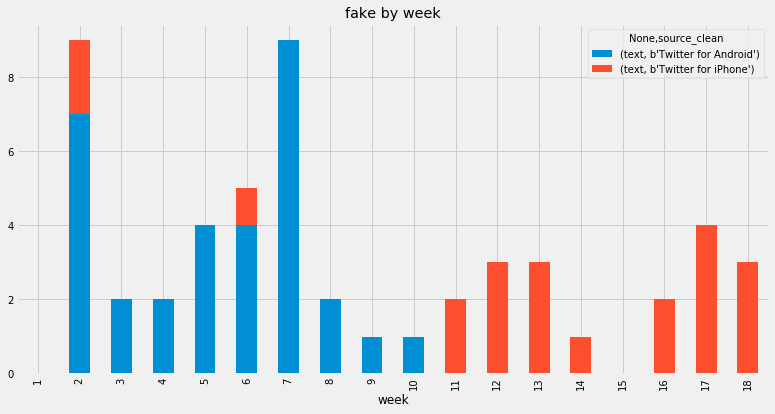

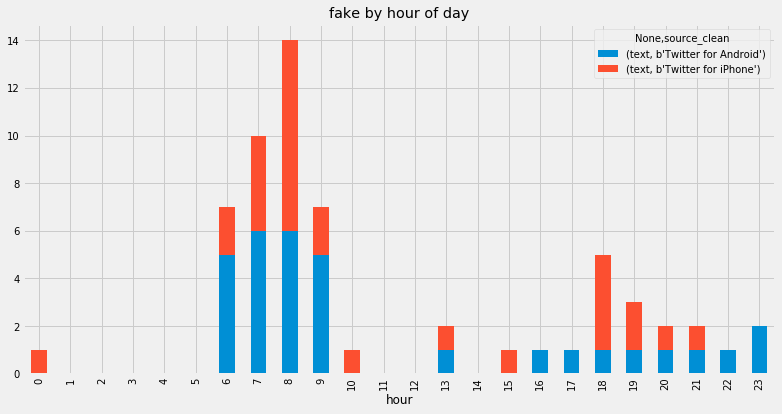

### The Tweets

[Wednesday, May 10, 2017 8:57 AM](https://twitter.com/realDonaldTrump/status/862290442129461249): The Roger Stone report on @CNN is false - Fake News. Have not spoken to Roger in a long time - had nothing to do with my decision.

[Monday, May 8, 2017 6:50 PM](https://twitter.com/realDonaldTrump/status/861715019674910721): Biggest story today between Clapper &amp; Yates is on surveillance. Why doesn't the media report on this? #FakeNews!

[Monday, May 8, 2017 6:43 PM](https://twitter.com/realDonaldTrump/status/861713233786404864): Sally Yates made the fake media extremely unhappy today --- she said nothing but old news!

[Monday, May 8, 2017 6:41 PM](https://twitter.com/realDonaldTrump/status/861712617299210240): Director Clapper reiterated what everybody, including the fake media already knows- there is "no evidence" of collusion w/ Russia and Trump.

[Monday, May 8, 2017 7:57 AM](https://twitter.com/realDonaldTrump/status/861550676505219073): General Flynn was given the highest security clearance by the Obama Administration - but the Fake News seldom likes talking about that.

[Sunday, May 7, 2017 7:17 AM](https://twitter.com/realDonaldTrump/status/861178291671244800): RT @FoxNews: .@POTUS: "I'm not against the media. I'm against the FAKE media." #CashinIn https://t.co/F7mBIj7iVL

[Sunday, May 7, 2017 7:15 AM](https://twitter.com/realDonaldTrump/status/861177649179373569): When will the Fake Media ask about the Dems dealings with Russia &amp; why the DNC wouldn't allow the FBI to check their server or investigate?

[Friday, May 5, 2017 7:29 PM](https://twitter.com/realDonaldTrump/status/860637673744195584): Why is it that the Fake News rarely reports Ocare is on its last legs and that insurance companies are fleeing for their lives? It's dead!

[Friday, May 5, 2017 7:22 PM](https://twitter.com/realDonaldTrump/status/860635815277453313): Wow,the Fake News media did everything in its power to make the Republican Healthcare victory look as bad as possible.Far better than Ocare!

[Thursday, May 4, 2017 7:02 AM](https://twitter.com/realDonaldTrump/status/860087334519414784): The Fake News media is officially out of control. They will do or say anything in order to get attention - never been a time like this!

[Saturday, Apr 29, 2017 1:39 PM](https://twitter.com/realDonaldTrump/status/858375278686613504): Mainstream (FAKE) media refuses to state our long list of achievements, including 28 legislative signings, strong borders &amp; great optimism!

[Tuesday, Apr 25, 2017 8:36 AM](https://twitter.com/realDonaldTrump/status/856849388026687492): Don't let the fake media tell you that I have changed my position on the WALL. It will get built and help stop drugs, human trafficking etc.

[Monday, Apr 24, 2017 8:15 AM](https://twitter.com/realDonaldTrump/status/856481786938916865): The two fake news polls released yesterday, ABC &amp; NBC, while containing some very positive info, were totally wrong in General E. Watch!

[Sunday, Apr 23, 2017 3:48 PM](https://twitter.com/realDonaldTrump/status/856233279841849344): New polls out today are very good considering that much of the media is FAKE and almost always negative. Would still beat Hillary in .....

[Wednesday, Apr 19, 2017 12:09 AM](https://twitter.com/realDonaldTrump/status/854547423464759296): Despite major outside money, FAKE media support and eleven Republican candidates, BIG "R" win with runoff in Georgia. Glad to be of help!

[Monday, Apr 17, 2017 8:17 AM](https://twitter.com/realDonaldTrump/status/853945633903923200): The Fake Media (not Real Media) has gotten even worse since the election. Every story is badly slanted. We have to hold them to the truth!

[Sunday, Apr 2, 2017 8:56 AM](https://twitter.com/realDonaldTrump/status/848519587675201538): Anybody (especially  Fake News media) who thinks that Repeal &amp; Replace of ObamaCare is dead does not know the love and strength in R Party!

[Saturday, Apr 1, 2017 9:02 AM](https://twitter.com/realDonaldTrump/status/848158641056362496): It is the same Fake News Media that said there is "no path to victory for Trump" that is now pushing the phony Russia story. A total scam!

[Saturday, Apr 1, 2017 8:43 AM](https://twitter.com/realDonaldTrump/status/848153860602507264): When will Sleepy Eyes Chuck Todd and @NBCNews start talking about the Obama SURVEILLANCE SCANDAL and stop with the Fake Trump/Russia story?

[Tuesday, Mar 28, 2017 6:41 PM](https://twitter.com/realDonaldTrump/status/846854703183020032): Why doesn't Fake News talk about Podesta ties to Russia as covered by @FoxNews or money from Russia to Clinton - sale of  Uranium?

[Thursday, Mar 23, 2017 8:18 AM](https://twitter.com/realDonaldTrump/status/844886082663698436): Just watched the totally biased and fake news reports of the so-called Russia story on NBC and ABC. Such dishonesty!

[Monday, Mar 20, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/843803115044454402): Just heard Fake News CNN is doing polls again despite the fact that their election polls were a WAY OFF disaster. Much higher ratings at Fox

[Monday, Mar 20, 2017 6:35 AM](https://twitter.com/realDonaldTrump/status/843772976151642112): James Clapper and others stated that there is no evidence Potus colluded with Russia. This story is FAKE NEWS and everyone knows it!

[Saturday, Mar 18, 2017 9:15 AM](https://twitter.com/realDonaldTrump/status/843088518339612673): Despite what you have heard from the FAKE NEWS, I had a GREAT meeting with German Chancellor Angela Merkel. Nevertheless, Germany owes.....

[Wednesday, Mar 15, 2017 6:55 AM](https://twitter.com/realDonaldTrump/status/841966077005463553): Does anybody really believe that a reporter, who nobody ever heard of, "went to his mailbox" and found my tax returns? @NBCNews  FAKE NEWS!

[Tuesday, Mar 7, 2017 9:14 AM](https://twitter.com/realDonaldTrump/status/839116941956640768): Don't let the FAKE NEWS tell you that there is big infighting in the Trump Admin. We are getting along great, and getting major things done!

[Sunday, Feb 26, 2017 1:16 PM](https://twitter.com/realDonaldTrump/status/835916511944523777): Russia talk is FAKE NEWS put out by the Dems, and played up by the media, in order to mask the big election defeat and the illegal leaks!

[Friday, Feb 24, 2017 10:09 PM](https://twitter.com/realDonaldTrump/status/835325771858251776): FAKE NEWS media knowingly doesn't tell the truth. A great danger to our country. The failing @nytimes has become a joke. Likewise @CNN. Sad!

[Monday, Feb 20, 2017 9:15 AM](https://twitter.com/realDonaldTrump/status/833681539997253636): Give the public a break - The FAKE NEWS media is trying to say that large scale immigration in Sweden is working out just beautifully. NOT!

[Saturday, Feb 18, 2017 8:31 AM](https://twitter.com/realDonaldTrump/status/832945737625387008): Don't believe the main stream (fake news) media.The White House is running VERY WELL. I inherited a MESS and am in the process of fixing it.

[Friday, Feb 17, 2017 6:15 PM](https://twitter.com/realDonaldTrump/status/832730328108134402): "One of the most effective press conferences I've ever seen!" says Rush Limbaugh. Many agree.Yet FAKE MEDIA  calls it differently! Dishonest

[Friday, Feb 17, 2017 4:48 PM](https://twitter.com/realDonaldTrump/status/832708293516632065): The FAKE NEWS media (failing @nytimes, @NBCNews, @ABC, @CBS, @CNN) is not my enemy, it is the enemy of the American People!

[Friday, Feb 17, 2017 6:43 AM](https://twitter.com/realDonaldTrump/status/832555987299082242): Thank you for all of the nice statements on the Press Conference yesterday. Rush Limbaugh said one of greatest ever. Fake media not happy!

[Thursday, Feb 16, 2017 9:39 AM](https://twitter.com/realDonaldTrump/status/832238070460186625): The Democrats had to come up with a story as to why they lost the election, and so badly (306), so they made up a story - RUSSIA. Fake news!

[Thursday, Feb 16, 2017 9:10 AM](https://twitter.com/realDonaldTrump/status/832230758299340800): FAKE NEWS media, which makes up stories and "sources," is far more effective than the discredited Democrats - but they are fading fast!

[Wednesday, Feb 15, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/831830548565852160): The fake news media is going crazy with their conspiracy theories and blind hatred. @MSNBC &amp; @CNN are unwatchable. @foxandfriends is great!

[Sunday, Feb 12, 2017 5:19 PM](https://twitter.com/realDonaldTrump/status/830904083519242241): Just leaving Florida. Big crowds of enthusiastic supporters lining the road that the FAKE NEWS media refuses to mention. Very dishonest!

[Sunday, Feb 12, 2017 7:14 AM](https://twitter.com/realDonaldTrump/status/830751875578355713): While on FAKE NEWS @CNN, Bernie Sanders was cut off for using the term fake news to describe the network. They said technical difficulties!

[Friday, Feb 10, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/830047626414477312): The failing @nytimes does major FAKE NEWS China story saying "Mr.Xi has not spoken to Mr. Trump since Nov.14." We spoke at length yesterday!

[Thursday, Feb 9, 2017 8:19 AM](https://twitter.com/realDonaldTrump/status/829681034564341760): Chris Cuomo, in his interview with Sen. Blumenthal, never asked him about his long-term lie about his brave "service" in Vietnam. FAKE NEWS!

[Wednesday, Feb 8, 2017 10:54 AM](https://twitter.com/realDonaldTrump/status/829357626798530561): '16 Fake News Stories Reporters Have Run Since Trump Won' https://t.co/0dHld5kiVc

[Monday, Feb 6, 2017 7:07 AM](https://twitter.com/realDonaldTrump/status/828575949268606977): I call my own shots, largely based on an accumulation of data, and everyone knows it. Some FAKE NEWS media, in order to marginalize, lies!

[Monday, Feb 6, 2017 7:01 AM](https://twitter.com/realDonaldTrump/status/828574430800539648): Any negative polls are fake news, just like the CNN, ABC, NBC polls in the election. Sorry, people want border security and extreme vetting.

[Saturday, Feb 4, 2017 8:39 AM](https://twitter.com/realDonaldTrump/status/827874208021639168): After being forced to apologize for its bad and inaccurate coverage of me after winning the election, the FAKE NEWS @nytimes is still lost!

[Friday, Feb 3, 2017 6:34 AM](https://twitter.com/realDonaldTrump/status/827480386120929280): Thank you to Prime Minister of Australia for telling the truth about our very civil conversation that FAKE NEWS media lied about. Very nice!

[Tuesday, Jan 31, 2017 6:21 AM](https://twitter.com/realDonaldTrump/status/826390034693623809): Nancy Pelosi and Fake Tears Chuck Schumer held a rally  at the steps of The Supreme Court and mic did not work (a mess)-just like Dem party!

[Sunday, Jan 29, 2017 8:00 AM](https://twitter.com/realDonaldTrump/status/825690087857995776): Somebody with aptitude and conviction should buy the FAKE NEWS and failing @nytimes and either run it correctly or let it fold with dignity!

[Saturday, Jan 28, 2017 8:04 AM](https://twitter.com/realDonaldTrump/status/825328817833123840): The failing @nytimes has been wrong about me from the very beginning. Said I would lose the primaries, then the general election. FAKE NEWS!

[Tuesday, Jan 24, 2017 9:16 PM](https://twitter.com/realDonaldTrump/status/824078417213747200): Congratulations to @FoxNews for being number one in inauguration ratings. They were many times higher than FAKE NEWS @CNN - public is smart!

[Wednesday, Jan 18, 2017 7:44 AM](https://twitter.com/realDonaldTrump/status/821699672687448064): to the U.S., but had nothing to do with TRUMP, is more FAKE NEWS. Ask top CEO's of those companies for real facts. Came back because of me!

[Sunday, Jan 15, 2017 7:29 PM](https://twitter.com/realDonaldTrump/status/820789938887294977): much worse - just look at Syria (red line), Crimea, Ukraine and the build-up of Russian nukes. Not good! Was this the leaker of Fake News?

[Friday, Jan 13, 2017 6:11 AM](https://twitter.com/realDonaldTrump/status/819864373988573184): Totally made up facts by sleazebag political operatives, both Democrats and Republicans - FAKE NEWS! Russia says nothing exists. Probably...

[Thursday, Jan 12, 2017 9:22 AM](https://twitter.com/realDonaldTrump/status/819550083742109696): .@CNN is in a total meltdown with their FAKE NEWS because their ratings are tanking since election and their credibility will soon be gone!

[Wednesday, Jan 11, 2017 11:01 PM](https://twitter.com/realDonaldTrump/status/819393877174087682): We had a great News Conference at Trump Tower today. A couple of FAKE NEWS organizations were there but the people truly get what's going on

[Wednesday, Jan 11, 2017 7:48 AM](https://twitter.com/realDonaldTrump/status/819164172781060096): Intelligence agencies should never have allowed this fake news to "leak" into the public. One last shot at me.Are we living in Nazi Germany?

[Wednesday, Jan 11, 2017 7:44 AM](https://twitter.com/realDonaldTrump/status/819162968592183298): I win an election easily, a great "movement" is verified, and crooked opponents try to belittle our victory with FAKE NEWS. A sorry state!

[Tuesday, Jan 10, 2017 9:00 PM](https://twitter.com/realDonaldTrump/status/819000924207251456): 'BuzzFeed Runs Unverifiable Trump-Russia Claims' #FakeNews 
https://t.co/d6daCFZHNh

[Tuesday, Jan 10, 2017 8:35 PM](https://twitter.com/realDonaldTrump/status/818994757569564673): RT @MichaelCohen212: I have never been to Prague in my life. #fakenews https://t.co/CMil9Rha3D

[Tuesday, Jan 10, 2017 8:19 PM](https://twitter.com/realDonaldTrump/status/818990655418617856): FAKE NEWS - A TOTAL POLITICAL WITCH HUNT!

[Sunday, Jan 8, 2017 11:05 PM](https://twitter.com/realDonaldTrump/status/818307689323368448): Dishonest media says Mexico won't be paying for the wall if they pay a little later so the wall can be built more quickly. Media is fake!

---

## Search: _mexic_

Number of Tweets: 14

Percent of all Tweets: 1.97%

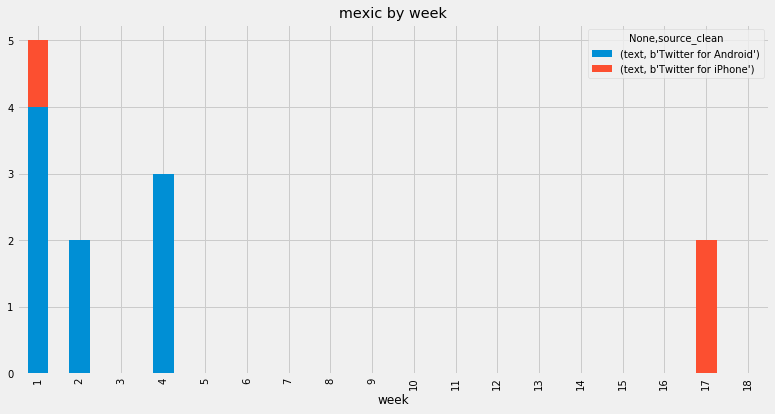

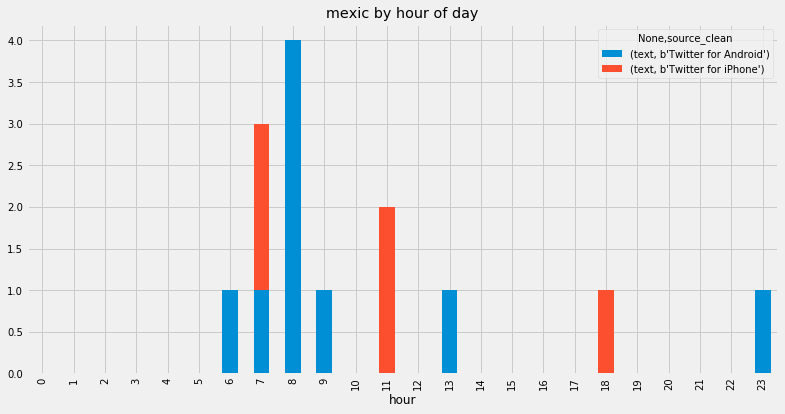

### The Tweets

[Wednesday, May 10, 2017 7:21 AM](https://twitter.com/realDonaldTrump/status/862266225157689349): RT @DRUDGE_REPORT: MEXICO 2ND DEADLIEST COUNTRY; TOPS AFGHAN, IRAQ... https://t.co/i4FtSpLiHV

[Sunday, May 7, 2017 6:58 PM](https://twitter.com/realDonaldTrump/status/861354654856249344): Rexnord of Indiana made a deal during the Obama Administration to move to Mexico. Fired their employees. Tax product big that's sold in U.S.

[Thursday, Apr 27, 2017 7:12 AM](https://twitter.com/realDonaldTrump/status/857552956836786177): I received calls from the President of Mexico and the Prime Minister of Canada asking to renegotiate NAFTA rather than terminate. I agreed..

[Sunday, Apr 23, 2017 11:44 AM](https://twitter.com/realDonaldTrump/status/856172056932700164): Eventually, but at a later date so we can get started early, Mexico will be paying, in some form, for the badly needed border wall.

[Friday, Jan 27, 2017 8:19 AM](https://twitter.com/realDonaldTrump/status/824970003153842176): Mexico has taken advantage of the U.S. for long enough. Massive trade deficits &amp; little help on the very weak border must change, NOW!

[Thursday, Jan 26, 2017 8:55 AM](https://twitter.com/realDonaldTrump/status/824616644370714627): of jobs and companies lost. If Mexico is unwilling to pay for the badly needed wall, then it would be better to cancel the upcoming meeting.

[Thursday, Jan 26, 2017 8:51 AM](https://twitter.com/realDonaldTrump/status/824615820391305216): The U.S. has a 60 billion dollar trade deficit with Mexico. It has been a one-sided deal from the beginning of NAFTA with massive numbers...

[Monday, Jan 9, 2017 9:16 AM](https://twitter.com/realDonaldTrump/status/818461467766824961): Ford said last week that it will expand in Michigan and U.S. instead of building a BILLION dollar plant in Mexico. Thank you Ford &amp; Fiat C!

[Sunday, Jan 8, 2017 11:05 PM](https://twitter.com/realDonaldTrump/status/818307689323368448): Dishonest media says Mexico won't be paying for the wall if they pay a little later so the wall can be built more quickly. Media is fake!

[Friday, Jan 6, 2017 6:19 AM](https://twitter.com/realDonaldTrump/status/817329823374831617): The dishonest media does not report that any money spent on building the Great Wall (for sake of speed), will be paid back by Mexico later!

[Thursday, Jan 5, 2017 1:14 PM](https://twitter.com/realDonaldTrump/status/817071792711942145): Toyota Motor said will build a new plant in Baja, Mexico, to build Corolla cars for U.S. NO WAY! Build plant in U.S. or pay big border tax.

[Wednesday, Jan 4, 2017 8:19 AM](https://twitter.com/realDonaldTrump/status/816635078067490816): Thank you to Ford for scrapping a new plant in Mexico and creating 700 new jobs in the U.S. This is just the beginning - much more to follow

[Tuesday, Jan 3, 2017 11:44 AM](https://twitter.com/realDonaldTrump/status/816324295781740544): "@DanScavino: Ford to scrap Mexico plant, invest in Michigan due to Trump policies"
https://t.co/137nUo03Gl

[Tuesday, Jan 3, 2017 7:30 AM](https://twitter.com/realDonaldTrump/status/816260343391514624): General Motors is sending Mexican made model of Chevy Cruze to U.S. car dealers-tax free across border. Make in U.S.A.or pay big border tax!

---

## Search: _fox_

Number of Tweets: 42

Percent of all Tweets: 5.91%

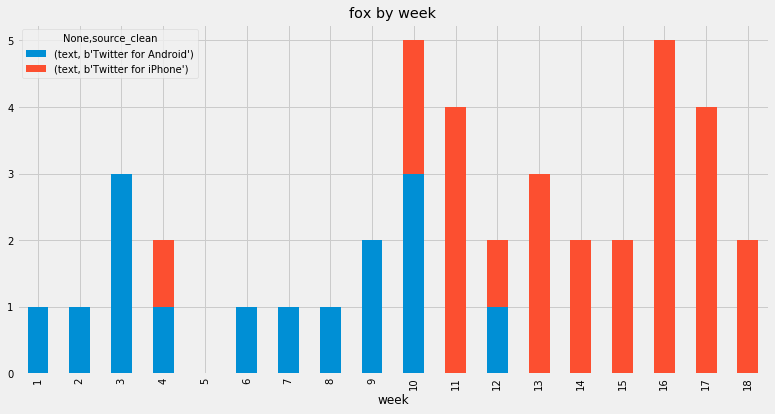

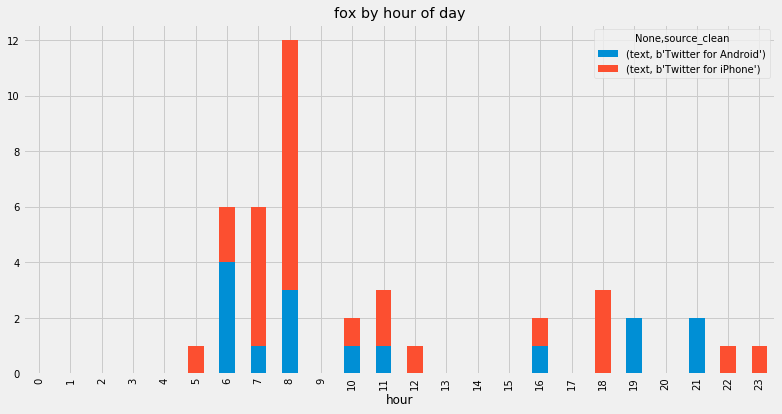

### The Tweets

[Sunday, May 7, 2017 7:17 AM](https://twitter.com/realDonaldTrump/status/861178291671244800): RT @FoxNews: .@POTUS: "I'm not against the media. I'm against the FAKE media." #CashinIn https://t.co/F7mBIj7iVL

[Thursday, May 4, 2017 7:09 AM](https://twitter.com/realDonaldTrump/status/860088977277235201): RT @foxandfriends: President Trump to sign an executive order on religious liberty today, the National Day of Prayer | @kevincorke https://…

[Thursday, May 4, 2017 7:07 AM](https://twitter.com/realDonaldTrump/status/860088511202029569): Congratulations to @foxandfriends on its unbelievable ratings hike.

[Friday, Apr 28, 2017 10:34 PM](https://twitter.com/realDonaldTrump/status/858147464846729217): RT @foxnation: . @TuckerCarlson : #Dems Don't Really Believe #Trump Is a Pawn of #Russia - That's Just Their Political Tool  https://t.co/K…

[Friday, Apr 28, 2017 6:31 PM](https://twitter.com/realDonaldTrump/status/858086278037950464): I will be interviewed by @MarthaMaccallum on @FoxNews tonight at 7pm. Enjoy!

[Friday, Apr 28, 2017 8:12 AM](https://twitter.com/realDonaldTrump/status/857930456767111168): RT @foxandfriends: Former President Obama's $400K Wall Street speech stuns liberal base; Sen. Warren saying she "was troubled by that" http…

[Sunday, Apr 23, 2017 10:07 AM](https://twitter.com/realDonaldTrump/status/856147612952612864): Thank you Lake Worth, Florida. @foxandfriends

[Saturday, Apr 22, 2017 11:18 AM](https://twitter.com/realDonaldTrump/status/855803080310390784): RT @foxandfriends: Israeli PM Netanyahu praises U.S. policy changes during meeting with Defense. Sec Mattis https://t.co/v2C9oaq3uY

[Saturday, Apr 22, 2017 11:18 AM](https://twitter.com/realDonaldTrump/status/855802920956243969): RT @foxandfriends: Chicago approves new plan to hide illegal immigrants from the feds, plus give them access to city services https://t.co/…

[Friday, Apr 21, 2017 6:11 AM](https://twitter.com/realDonaldTrump/status/855363343607103489): RT @foxandfriends: NYT editor apologizes for misleading tweet about New England Patriots' visit to the White House (via @FoxFriendsFirst) h…

[Tuesday, Apr 18, 2017 5:48 AM](https://twitter.com/realDonaldTrump/status/854270321620287490): I will be interviewed on @foxandfriends by @ainsleyearhardt starting at 6:00 A.M. Enjoy!

[Monday, Apr 17, 2017 8:07 AM](https://twitter.com/realDonaldTrump/status/853942936337350656): "The first 90 days of my presidency has exposed the total failure of the last eight years of foreign policy!" So true. @foxandfriends

[Tuesday, Apr 11, 2017 11:16 PM](https://twitter.com/realDonaldTrump/status/851997299454742528): I will be interviewed by @MariaBartiromo at 6:00 A.M. @FoxBusiness. Enjoy!

[Tuesday, Apr 11, 2017 7:48 AM](https://twitter.com/realDonaldTrump/status/851763890786635776): RT @foxnation: Grateful Syrians React To @realDonaldTrump Strike: 'I'll Name My Son Donald' https://t.co/7KexXsXLUx #SyrianStrikes

[Monday, Apr 3, 2017 8:51 AM](https://twitter.com/realDonaldTrump/status/848880519458717698): .@FoxNews from multiple sources: "There was electronic surveillance of Trump, and people close to Trump. This is unprecedented." @FBI

[Monday, Apr 3, 2017 6:15 AM](https://twitter.com/realDonaldTrump/status/848841326183534594): Such amazing reporting on unmasking and the crooked scheme against us by @foxandfriends. "Spied on before nomination." The real story.

[Saturday, Apr 1, 2017 12:50 PM](https://twitter.com/realDonaldTrump/status/848216035153121285): Wow, @FoxNews just reporting big news. Source: "Official behind unmasking is high up. Known Intel official is responsible. Some unmasked....

[Tuesday, Mar 28, 2017 6:41 PM](https://twitter.com/realDonaldTrump/status/846854703183020032): Why doesn't Fake News talk about Podesta ties to Russia as covered by @FoxNews or money from Russia to Clinton - sale of  Uranium?

[Tuesday, Mar 28, 2017 7:16 AM](https://twitter.com/realDonaldTrump/status/846682464215076866): Watch @foxandfriends now on Podesta and Russia!

[Saturday, Mar 25, 2017 10:41 AM](https://twitter.com/realDonaldTrump/status/845646761704243200): Watch @JudgeJeanine on @FoxNews tonight at 9:00 P.M.

[Monday, Mar 20, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/843803115044454402): Just heard Fake News CNN is doing polls again despite the fact that their election polls were a WAY OFF disaster. Much higher ratings at Fox

[Friday, Mar 17, 2017 8:34 AM](https://twitter.com/realDonaldTrump/status/842715710765830147): RT @foxandfriends: FOX NEWS ALERT: Jihadis using religious visa to enter US, experts warn (via @FoxFriendsFirst) https://t.co/pwXeR9OMQC

[Friday, Mar 17, 2017 8:30 AM](https://twitter.com/realDonaldTrump/status/842714739365105664): RT @foxandfriends: VIDEO: Rep. Scalise — GOP agrees on over 85 percent of health care bill https://t.co/05dtfjAUbx

[Friday, Mar 17, 2017 8:20 AM](https://twitter.com/realDonaldTrump/status/842712210896052225): RT @FoxNews: Jobs created in February. https://t.co/sOaMDxxTA8

[Wednesday, Mar 15, 2017 4:55 PM](https://twitter.com/realDonaldTrump/status/842117164144431104): I will be interviewed by @TuckerCarlson tonight at 9:00 P.M. on @FoxNews. Enjoy!

[Friday, Mar 10, 2017 8:32 AM](https://twitter.com/realDonaldTrump/status/840193545046773760): RT @foxandfriends: "Never give up....that's the worst thing you could do. There's always a chance." -Kyle Coddington's message to those als…

[Thursday, Mar 9, 2017 8:13 AM](https://twitter.com/realDonaldTrump/status/839826581354921984): RT @foxnation: .@realDonaldTrump's First Full Month in Office Sees Biggest Jobs Gain 'In Years': Report: https://t.co/rx4bgI1MWK

[Tuesday, Mar 7, 2017 8:41 AM](https://twitter.com/realDonaldTrump/status/839108868584124417): Don't worry, getting rid of state lines, which will promote competition, will be in phase 2 &amp; 3 of healthcare rollout. @foxandfriends

[Tuesday, Mar 7, 2017 8:13 AM](https://twitter.com/realDonaldTrump/status/839101660886614016): For eight years Russia "ran over" President Obama, got stronger and stronger, picked-off Crimea and added missiles. Weak! @foxandfriends

[Sunday, Mar 5, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/838353481526312961): Who was it that secretly said to Russian President, "Tell Vladimir that after the election I'll have more flexibility?" @foxandfriends

[Friday, Mar 3, 2017 7:00 AM](https://twitter.com/realDonaldTrump/status/837633820417482754): Nick Adams new book, Green Card Warrior, is a must read. The merit-based system is the way to go. Canada, Australia! @foxandfriends

[Monday, Feb 27, 2017 9:43 PM](https://twitter.com/realDonaldTrump/status/836406328369242113): I will be interviewed on @foxandfriends at 6:00 A.M. Enjoy!

[Sunday, Feb 19, 2017 4:57 PM](https://twitter.com/realDonaldTrump/status/833435244451753984): My statement as to what's happening in Sweden was in reference to a story that was broadcast on @FoxNews concerning immigrants &amp; Sweden.

[Wednesday, Feb 15, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/831830548565852160): The fake news media is going crazy with their conspiracy theories and blind hatred. @MSNBC &amp; @CNN are unwatchable. @foxandfriends is great!

[Saturday, Feb 4, 2017 7:34 PM](https://twitter.com/realDonaldTrump/status/828039143318024194): Interview with @oreillyfactor on Fox Network - 4:00 P.M. (prior to Super Bowl). Enjoy!

[Thursday, Jan 26, 2017 6:45 PM](https://twitter.com/realDonaldTrump/status/824765229527605248): Will be interviewed by @SeanHannity on @FoxNews at 10:00pm tonight. Enjoy!

[Tuesday, Jan 24, 2017 9:16 PM](https://twitter.com/realDonaldTrump/status/824078417213747200): Congratulations to @FoxNews for being number one in inauguration ratings. They were many times higher than FAKE NEWS @CNN - public is smart!

[Saturday, Jan 21, 2017 6:53 AM](https://twitter.com/realDonaldTrump/status/822774162011910144): A fantastic day and evening in Washington D.C.Thank you to @FoxNews and so many other news outlets for the GREAT reviews of the speech!

[Wednesday, Jan 18, 2017 6:53 AM](https://twitter.com/realDonaldTrump/status/821686928680583169): Will be interviewed by @ainsleyearhardt on @foxandfriends - Enjoy!

[Sunday, Jan 15, 2017 7:16 PM](https://twitter.com/realDonaldTrump/status/820786730257285120): .@FoxNews "Outgoing CIA Chief, John Brennan, blasts Pres-Elect Trump on Russia threat. Does not fully understand." Oh really, couldn't do...

[Sunday, Jan 8, 2017 11:39 AM](https://twitter.com/realDonaldTrump/status/818134981344165888): "@FoxNews: "We certainly don’t want intelligence interfering with politics and we don’t want politics interfe… https://t.co/bwDjEg1d7S"

[Wednesday, Jan 4, 2017 8:10 AM](https://twitter.com/realDonaldTrump/status/816632793862176769): "@FoxNews: Julian Assange on U.S. media coverage: “It’s very dishonest.” #Hannity https://t.co/ADcPRQifH9" More dishonest than anyone knows

---

## Search: _terror_

Number of Tweets: 9

Percent of all Tweets: 1.27%

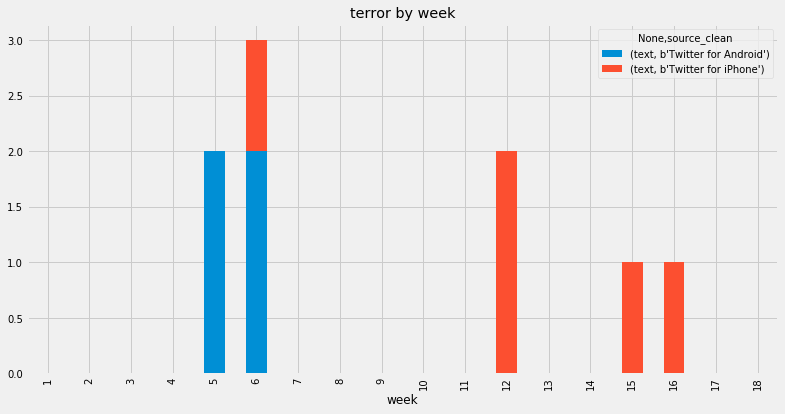

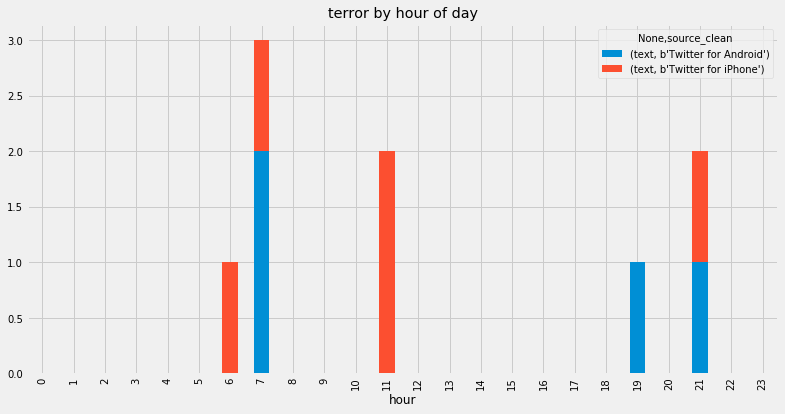

### The Tweets

[Friday, Apr 21, 2017 6:32 AM](https://twitter.com/realDonaldTrump/status/855368516920332289): Another terrorist attack in Paris. The people of France will not take much more of this. Will have a big effect on presidential election!

[Sunday, Apr 9, 2017 11:20 AM](https://twitter.com/realDonaldTrump/status/851092500056072198): So sad to hear of the terrorist attack in Egypt. U.S. strongly condemns. I have great...

[Thursday, Mar 23, 2017 11:16 AM](https://twitter.com/realDonaldTrump/status/844930836663357440): A great American, Kurt Cochran, was killed in the London terror attack. My prayers and condolences are with his family and friends.

[Wednesday, Mar 22, 2017 9:33 PM](https://twitter.com/realDonaldTrump/status/844723847094026242): Spoke to U.K. Prime Minister Theresa May today to offer condolences on the terrorist attack in London. She is strong and doing very well.

[Tuesday, Feb 7, 2017 7:11 AM](https://twitter.com/realDonaldTrump/status/828939235499638784): I don't know Putin, have no deals in Russia, and the haters are going crazy - yet Obama can make a deal with Iran, #1 in terror, no problem!

[Monday, Feb 6, 2017 9:49 PM](https://twitter.com/realDonaldTrump/status/828797801630937089): The threat from radical Islamic terrorism is very real, just look at what is happening in Europe and the Middle-East. Courts must act fast!

[Saturday, Feb 4, 2017 7:48 PM](https://twitter.com/realDonaldTrump/status/828042506851934209): The judge opens up our country to potential terrorists and others that do not have our best interests at heart. Bad people are very happy!

[Friday, Feb 3, 2017 7:51 AM](https://twitter.com/realDonaldTrump/status/827499871011819520): A new radical Islamic terrorist has just attacked in Louvre Museum in Paris. Tourists were locked down. France on edge again. GET SMART U.S.

[Monday, Jan 30, 2017 7:27 AM](https://twitter.com/realDonaldTrump/status/826044059647107073): There is nothing nice about searching for terrorists before they can enter our country. This was a big part of my campaign. Study the world!

---

## Search: _ivanka_

Number of Tweets: 10

Percent of all Tweets: 1.41%

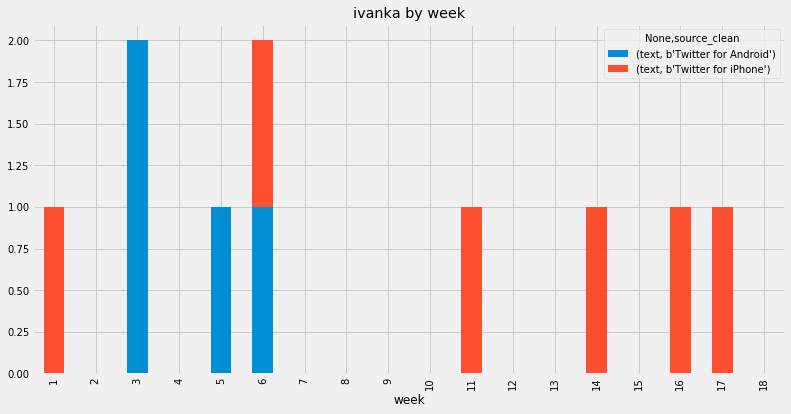

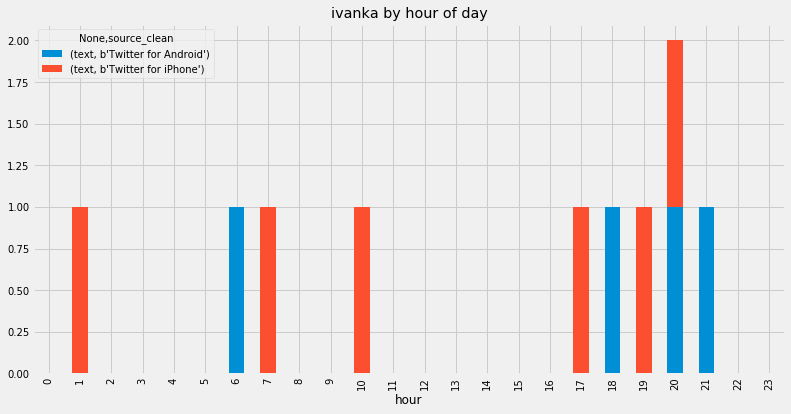

### The Tweets

[Tuesday, Apr 25, 2017 7:23 AM](https://twitter.com/realDonaldTrump/status/856830933709750272): Proud of @IvankaTrump for her leadership on these important issues. Looking forward to hearing her speak at the W20! https://t.co/e6Uajrm8zp

[Friday, Apr 21, 2017 8:19 PM](https://twitter.com/realDonaldTrump/status/855576880048738304): RT @Scavino45: .@POTUS @realDonaldTrump, @IvankaTrump, Jared Kushner, &amp; Dina Powell in the Oval Office today w/ Aya &amp; her brother Basel.
#W…

[Friday, Apr 7, 2017 7:22 PM](https://twitter.com/realDonaldTrump/status/850489084221018113): RT @IvankaTrump: Very proud of Arabella and Joseph for their performance in honor of President Xi Jinping and Madame Peng Liyuan's official…

[Thursday, Mar 16, 2017 5:43 PM](https://twitter.com/realDonaldTrump/status/842491443675611138): RT @USHCC: USHCC was delighted to host @IvankaTrump for a roundtable discussion w/ Hispanic women biz owners today in Washington #USHCCLegi…

[Saturday, Feb 11, 2017 6:00 PM](https://twitter.com/realDonaldTrump/status/830552079240409089): I am so proud of my daughter Ivanka. To be abused and treated so badly by the media, and to still hold her head so high, is truly wonderful!

[Wednesday, Feb 8, 2017 10:51 AM](https://twitter.com/realDonaldTrump/status/829356871848951809): My daughter Ivanka has been treated so unfairly by @Nordstrom. She is a great person -- always pushing me to do the right thing! Terrible!

[Thursday, Feb 2, 2017 6:25 AM](https://twitter.com/realDonaldTrump/status/827115768202534913): Attending Chief Ryan Owens' Dignified Transfer yesterday with my daughter Ivanka was my great honor. To a great and brave man - thank you!

[Monday, Jan 16, 2017 9:08 PM](https://twitter.com/realDonaldTrump/status/821177307708661761): "@drgoodspine: @realDonaldTrump @Ivanka Trump is great, a woman with real character and class."

[Monday, Jan 16, 2017 8:49 PM](https://twitter.com/realDonaldTrump/status/821172595869577220): At 9:00 P.M. @CNN, of all places, is doing a Special Report on my daughter, Ivanka. Considering it is CNN, can't imagine it will be great!

[Sunday, Jan 1, 2017 1:49 AM](https://twitter.com/realDonaldTrump/status/815449933453127681): RT @IvankaTrump: 2016 has been one of the most eventful and exciting years of my life. I wish you peace, joy, love and laughter. Happy New…

---

## Search: _ms 13_

Number of Tweets: 2

Percent of all Tweets: 0.28%

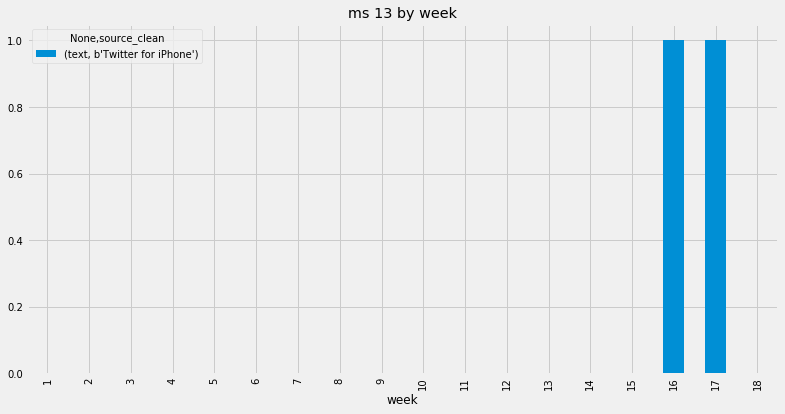

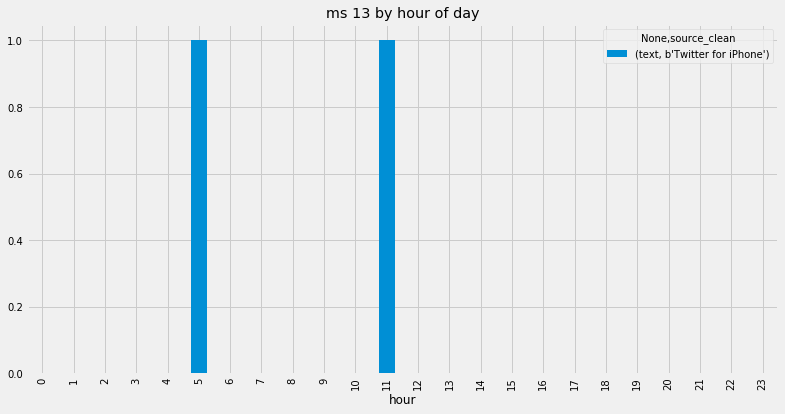

### The Tweets

[Sunday, Apr 23, 2017 11:42 AM](https://twitter.com/realDonaldTrump/status/856171332521820165): The Democrats don't want money from budget going to border wall despite the fact that it will stop drugs and very bad MS 13 gang members.

[Tuesday, Apr 18, 2017 5:39 AM](https://twitter.com/realDonaldTrump/status/854268119774367745): The weak illegal immigration policies of the Obama Admin. allowed bad MS 13 gangs to form in cities across U.S. We are removing them fast!

---

## Search: _russia_

Number of Tweets: 42

Percent of all Tweets: 5.91%

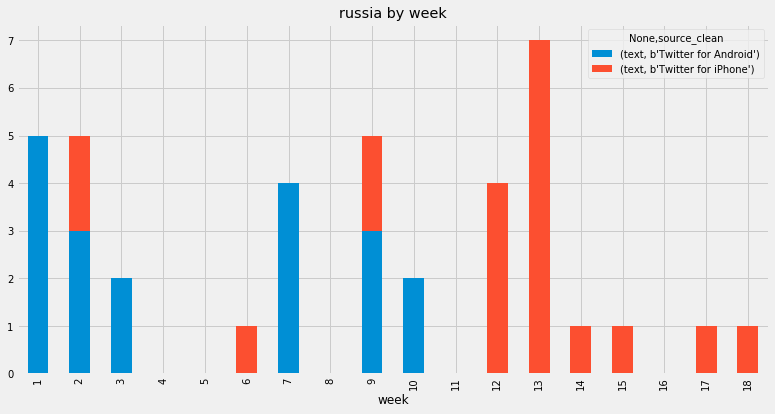

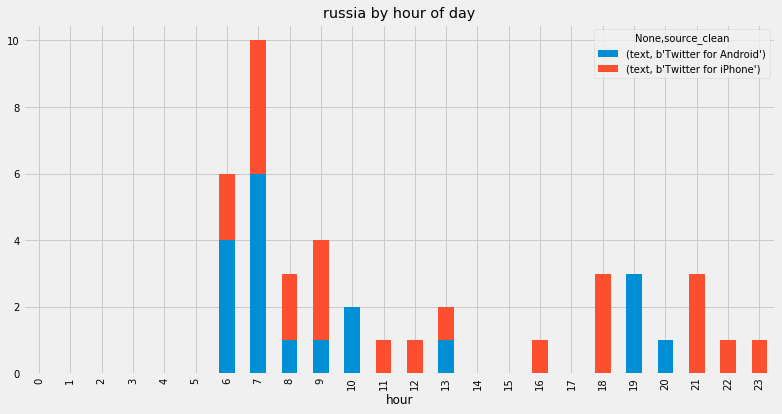

### The Tweets

[Monday, May 8, 2017 6:46 PM](https://twitter.com/realDonaldTrump/status/861713823505494016): The Russia-Trump collusion story is a total hoax, when will this taxpayer funded charade end?

[Monday, May 8, 2017 6:41 PM](https://twitter.com/realDonaldTrump/status/861712617299210240): Director Clapper reiterated what everybody, including the fake media already knows- there is "no evidence" of collusion w/ Russia and Trump.

[Sunday, May 7, 2017 7:15 AM](https://twitter.com/realDonaldTrump/status/861177649179373569): When will the Fake Media ask about the Dems dealings with Russia &amp; why the DNC wouldn't allow the FBI to check their server or investigate?

[Tuesday, May 2, 2017 11:06 PM](https://twitter.com/realDonaldTrump/status/859604996236742656): ...Trump/Russia story was an excuse used by the Democrats as justification for losing the election. Perhaps Trump just ran a great campaign?

[Friday, Apr 28, 2017 10:34 PM](https://twitter.com/realDonaldTrump/status/858147464846729217): RT @foxnation: . @TuckerCarlson : #Dems Don't Really Believe #Trump Is a Pawn of #Russia - That's Just Their Political Tool  https://t.co/K…

[Thursday, Apr 13, 2017 9:16 AM](https://twitter.com/realDonaldTrump/status/852510810287075329): Things will work out fine between the U.S.A. and Russia. At the right time everyone will come to their senses &amp; there will be lasting peace!

[Monday, Apr 3, 2017 7:16 AM](https://twitter.com/realDonaldTrump/status/848856822312292354): Was the brother of John Podesta paid big money to get the sanctions on Russia lifted? Did Hillary know?

[Saturday, Apr 1, 2017 1:02 PM](https://twitter.com/realDonaldTrump/status/848219027659010051): ..not associated with Russia. Trump team spied on before he was nominated." If this is true, does not get much bigger. Would be sad for U.S.

[Saturday, Apr 1, 2017 9:02 AM](https://twitter.com/realDonaldTrump/status/848158641056362496): It is the same Fake News Media that said there is "no path to victory for Trump" that is now pushing the phony Russia story. A total scam!

[Saturday, Apr 1, 2017 8:43 AM](https://twitter.com/realDonaldTrump/status/848153860602507264): When will Sleepy Eyes Chuck Todd and @NBCNews start talking about the Obama SURVEILLANCE SCANDAL and stop with the Fake Trump/Russia story?

[Tuesday, Mar 28, 2017 6:41 PM](https://twitter.com/realDonaldTrump/status/846854703183020032): Why doesn't Fake News talk about Podesta ties to Russia as covered by @FoxNews or money from Russia to Clinton - sale of  Uranium?

[Tuesday, Mar 28, 2017 7:16 AM](https://twitter.com/realDonaldTrump/status/846682464215076866): Watch @foxandfriends now on Podesta and Russia!

[Monday, Mar 27, 2017 9:35 PM](https://twitter.com/realDonaldTrump/status/846536212362018816): ...money to Bill, the Hillary Russian "reset," praise of Russia by Hillary, or Podesta Russian Company. Trump Russia story is a hoax. #MAGA!

[Monday, Mar 27, 2017 9:26 PM](https://twitter.com/realDonaldTrump/status/846533818811080704): Why isn't the House Intelligence Committee looking into the Bill &amp; Hillary deal that allowed big Uranium to go to Russia, Russian speech....

[Thursday, Mar 23, 2017 8:18 AM](https://twitter.com/realDonaldTrump/status/844886082663698436): Just watched the totally biased and fake news reports of the so-called Russia story on NBC and ABC. Such dishonesty!

[Monday, Mar 20, 2017 9:14 AM](https://twitter.com/realDonaldTrump/status/843813078076719107): What about all of the contact with the Clinton campaign and the Russians? Also, is it true that the DNC would not let the FBI in to look?

[Monday, Mar 20, 2017 6:49 AM](https://twitter.com/realDonaldTrump/status/843776582825267201): The Democrats made up and pushed the Russian story as an excuse for running a terrible campaign. Big advantage in Electoral College &amp; lost!

[Monday, Mar 20, 2017 6:35 AM](https://twitter.com/realDonaldTrump/status/843772976151642112): James Clapper and others stated that there is no evidence Potus colluded with Russia. This story is FAKE NEWS and everyone knows it!

[Tuesday, Mar 7, 2017 8:13 AM](https://twitter.com/realDonaldTrump/status/839101660886614016): For eight years Russia "ran over" President Obama, got stronger and stronger, picked-off Crimea and added missiles. Weak! @foxandfriends

[Sunday, Mar 5, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/838353481526312961): Who was it that secretly said to Russian President, "Tell Vladimir that after the election I'll have more flexibility?" @foxandfriends

[Saturday, Mar 4, 2017 6:42 AM](https://twitter.com/realDonaldTrump/status/837991759045079040): Just out: The same Russian Ambassador that met Jeff Sessions visited the Obama White House 22 times, and 4 times last year alone.

[Saturday, Mar 4, 2017 6:26 AM](https://twitter.com/realDonaldTrump/status/837987684660412416): The first meeting Jeff Sessions had with the Russian Amb was set up by the Obama Administration under education program for 100 Ambs......

[Friday, Mar 3, 2017 4:02 PM](https://twitter.com/realDonaldTrump/status/837770149767827456): I hereby demand a second investigation, after Schumer, of Pelosi for her close ties to Russia, and lying about it. https://t.co/qCDljfF3wN

[Friday, Mar 3, 2017 12:54 PM](https://twitter.com/realDonaldTrump/status/837722869106880517): We should start an immediate investigation into @SenSchumer and his ties to Russia and Putin. A total hypocrite! https://t.co/Ik3yqjHzsA

[Sunday, Feb 26, 2017 1:16 PM](https://twitter.com/realDonaldTrump/status/835916511944523777): Russia talk is FAKE NEWS put out by the Dems, and played up by the media, in order to mask the big election defeat and the illegal leaks!

[Thursday, Feb 16, 2017 9:39 AM](https://twitter.com/realDonaldTrump/status/832238070460186625): The Democrats had to come up with a story as to why they lost the election, and so badly (306), so they made up a story - RUSSIA. Fake news!

[Wednesday, Feb 15, 2017 7:42 AM](https://twitter.com/realDonaldTrump/status/831846101179314177): Crimea was TAKEN by Russia during the Obama Administration. Was Obama too soft on Russia?

[Wednesday, Feb 15, 2017 7:19 AM](https://twitter.com/realDonaldTrump/status/831840306161123328): Information is being illegally given to the failing @nytimes &amp; @washingtonpost by the intelligence community (NSA and FBI?).Just like Russia

[Wednesday, Feb 15, 2017 7:08 AM](https://twitter.com/realDonaldTrump/status/831837514226921472): This Russian connection non-sense is merely an attempt to cover-up the many mistakes made in Hillary Clinton's losing campaign.

[Tuesday, Feb 7, 2017 7:11 AM](https://twitter.com/realDonaldTrump/status/828939235499638784): I don't know Putin, have no deals in Russia, and the haters are going crazy - yet Obama can make a deal with Iran, #1 in terror, no problem!

[Sunday, Jan 15, 2017 7:29 PM](https://twitter.com/realDonaldTrump/status/820789938887294977): much worse - just look at Syria (red line), Crimea, Ukraine and the build-up of Russian nukes. Not good! Was this the leaker of Fake News?

[Sunday, Jan 15, 2017 7:16 PM](https://twitter.com/realDonaldTrump/status/820786730257285120): .@FoxNews "Outgoing CIA Chief, John Brennan, blasts Pres-Elect Trump on Russia threat. Does not fully understand." Oh really, couldn't do...

[Friday, Jan 13, 2017 6:11 AM](https://twitter.com/realDonaldTrump/status/819864373988573184): Totally made up facts by sleazebag political operatives, both Democrats and Republicans - FAKE NEWS! Russia says nothing exists. Probably...

[Wednesday, Jan 11, 2017 7:31 AM](https://twitter.com/realDonaldTrump/status/819159806489591809): Russia has never tried to use leverage over me. I HAVE NOTHING TO DO WITH RUSSIA - NO DEALS, NO LOANS, NO NOTHING!

[Wednesday, Jan 11, 2017 7:13 AM](https://twitter.com/realDonaldTrump/status/819155311793700865): Russia just said the unverified report paid for by political opponents is "A COMPLETE AND TOTAL FABRICATION, UTTER NONSENSE." Very unfair!

[Tuesday, Jan 10, 2017 9:00 PM](https://twitter.com/realDonaldTrump/status/819000924207251456): 'BuzzFeed Runs Unverifiable Trump-Russia Claims' #FakeNews 
https://t.co/d6daCFZHNh

[Sunday, Jan 8, 2017 11:57 AM](https://twitter.com/realDonaldTrump/status/818139647687753733): RT @MeetThePress: Watch our interview with @KellyannePolls: Russia "did not succeed" in attempts to sway election https://t.co/EZhgUIUbYx #…

[Saturday, Jan 7, 2017 10:10 AM](https://twitter.com/realDonaldTrump/status/817750330196819968): have enough problems around the world without yet another one. When I am President, Russia will respect us far more than they do now and....

[Saturday, Jan 7, 2017 10:02 AM](https://twitter.com/realDonaldTrump/status/817748207694467072): Having a good relationship with Russia is a good thing, not a bad thing. Only "stupid" people, or fools, would think that it is bad! We.....

[Thursday, Jan 5, 2017 7:30 PM](https://twitter.com/realDonaldTrump/status/817166353266262016): The Democratic National Committee would not allow the FBI to study or see its computer info after it was supposedly hacked by Russia......

[Wednesday, Jan 4, 2017 7:22 AM](https://twitter.com/realDonaldTrump/status/816620855958601730): Julian Assange said "a 14 year old could have hacked Podesta" - why was DNC so careless? Also said Russians did not give him the info!

[Tuesday, Jan 3, 2017 8:14 PM](https://twitter.com/realDonaldTrump/status/816452807024840704): The "Intelligence" briefing on so-called "Russian hacking" was delayed until Friday, perhaps more time needed to build a case. Very strange!

---

## Search: _failing_

Number of Tweets: 18

Percent of all Tweets: 2.53%

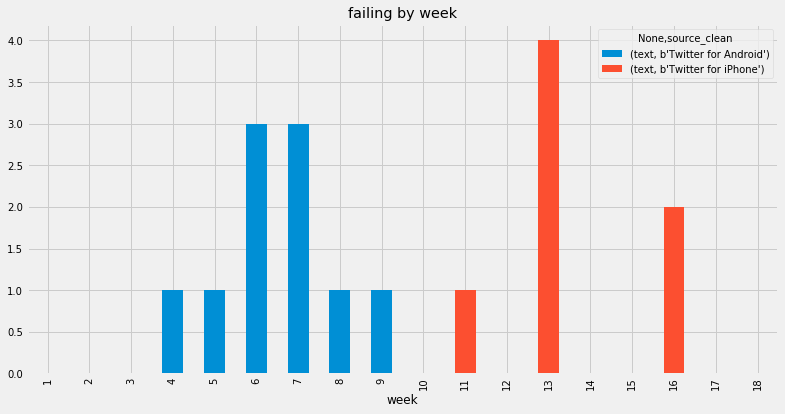

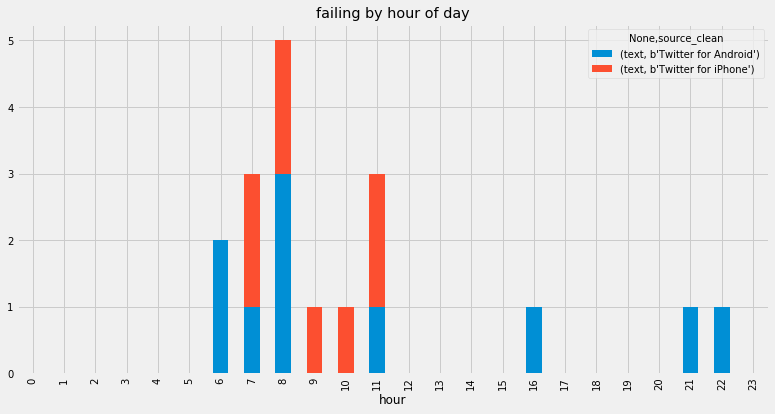

### The Tweets

[Sunday, May 7, 2017 7:37 AM](https://twitter.com/realDonaldTrump/status/861183225082806272): RT @brunelldonald: I thought about jobs that went overseas failing schools open borders not my skin color when I voted @realDonaldTrump! I…

[Thursday, Apr 20, 2017 9:48 AM](https://twitter.com/realDonaldTrump/status/855055509455593472): Failing @nytimes, which has been calling me wrong for two years, just got caught in a big lie concerning New England Patriots visit to W.H.

[Wednesday, Apr 19, 2017 8:43 AM](https://twitter.com/realDonaldTrump/status/854676780527079425): Dems failed in Kansas and are now failing in Georgia. Great job Karen Handel! It is now Hollywood vs. Georgia on June 20th.

[Saturday, Apr 1, 2017 11:59 AM](https://twitter.com/realDonaldTrump/status/848203201094483972): The failing @nytimes finally gets it - "In places where no insurance company offers plans, there will be no way for ObamaCare customers to..

[Thursday, Mar 30, 2017 10:27 AM](https://twitter.com/realDonaldTrump/status/847455180912181249): The failing @nytimes has disgraced the media world. Gotten me wrong for two solid years. Change libel laws? https://t.co/QIqLgvYLLi

[Wednesday, Mar 29, 2017 8:01 AM](https://twitter.com/realDonaldTrump/status/847056211006631936): Remember when the failing @nytimes apologized to its subscribers, right after the election, because their coverage was so wrong. Now worse!

[Tuesday, Mar 28, 2017 11:26 AM](https://twitter.com/realDonaldTrump/status/846745288735887360): The failing @NYTimes would do much better if they were honest! 
https://t.co/ATy8R3knS2

[Wednesday, Mar 15, 2017 7:02 AM](https://twitter.com/realDonaldTrump/status/841967881516679168): Can you imagine what the outcry would be if @SnoopDogg, failing career and all, had aimed and fired the gun at President Obama? Jail time!

[Sunday, Feb 26, 2017 6:42 AM](https://twitter.com/realDonaldTrump/status/835817351178301440): For first time the failing @nytimes will take an ad (a bad one) to help save its failing reputation. Try reporting accurately &amp; fairly!

[Friday, Feb 24, 2017 10:09 PM](https://twitter.com/realDonaldTrump/status/835325771858251776): FAKE NEWS media knowingly doesn't tell the truth. A great danger to our country. The failing @nytimes has become a joke. Likewise @CNN. Sad!

[Friday, Feb 17, 2017 4:48 PM](https://twitter.com/realDonaldTrump/status/832708293516632065): The FAKE NEWS media (failing @nytimes, @NBCNews, @ABC, @CBS, @CNN) is not my enemy, it is the enemy of the American People!

[Thursday, Feb 16, 2017 6:58 AM](https://twitter.com/realDonaldTrump/status/832197515248275456): Leaking, and even illegal classified leaking, has been a big problem in Washington for years. Failing @nytimes (and others) must apologize!

[Wednesday, Feb 15, 2017 7:19 AM](https://twitter.com/realDonaldTrump/status/831840306161123328): Information is being illegally given to the failing @nytimes &amp; @washingtonpost by the intelligence community (NSA and FBI?).Just like Russia

[Friday, Feb 10, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/830047626414477312): The failing @nytimes does major FAKE NEWS China story saying "Mr.Xi has not spoken to Mr. Trump since Nov.14." We spoke at length yesterday!

[Monday, Feb 6, 2017 9:33 PM](https://twitter.com/realDonaldTrump/status/828793887275761665): The failing @nytimes was forced to apologize to its subscribers for the poor reporting it did on my election win. Now they are worse!

[Monday, Feb 6, 2017 11:32 AM](https://twitter.com/realDonaldTrump/status/828642511698669569): The failing @nytimes writes total fiction concerning me. They have gotten it wrong for two years, and now are making up stories &amp; sources!

[Sunday, Jan 29, 2017 8:00 AM](https://twitter.com/realDonaldTrump/status/825690087857995776): Somebody with aptitude and conviction should buy the FAKE NEWS and failing @nytimes and either run it correctly or let it fold with dignity!

[Saturday, Jan 28, 2017 8:04 AM](https://twitter.com/realDonaldTrump/status/825328817833123840): The failing @nytimes has been wrong about me from the very beginning. Said I would lose the primaries, then the general election. FAKE NEWS!

---

## Search: _election_

Number of Tweets: 32

Percent of all Tweets: 4.50%

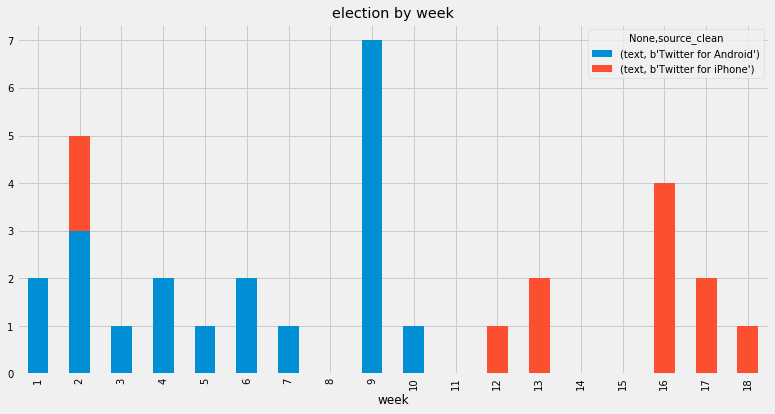

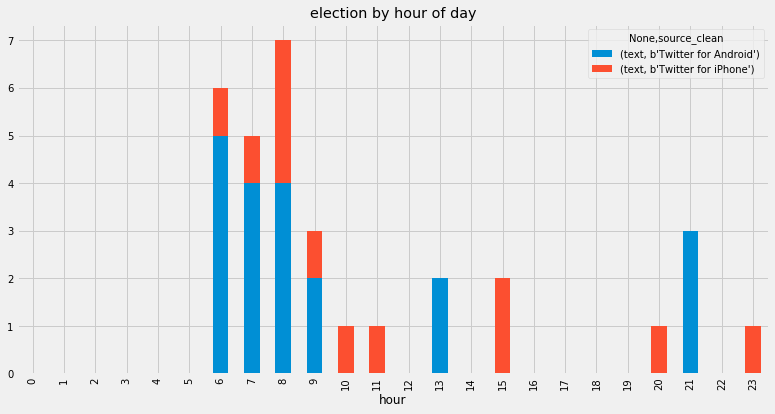

### The Tweets

[Tuesday, May 2, 2017 11:06 PM](https://twitter.com/realDonaldTrump/status/859604996236742656): ...Trump/Russia story was an excuse used by the Democrats as justification for losing the election. Perhaps Trump just ran a great campaign?

[Sunday, Apr 23, 2017 3:55 PM](https://twitter.com/realDonaldTrump/status/856234989591121922): ...popular vote. ABC News/Washington Post Poll (wrong big on election) said almost all stand by their vote on me &amp; 53% said strong leader.

[Sunday, Apr 23, 2017 10:05 AM](https://twitter.com/realDonaldTrump/status/856146924705120256): Very interesting election currently taking place in France.

[Friday, Apr 21, 2017 6:32 AM](https://twitter.com/realDonaldTrump/status/855368516920332289): Another terrorist attack in Paris. The people of France will not take much more of this. Will have a big effect on presidential election!

[Monday, Apr 17, 2017 8:17 AM](https://twitter.com/realDonaldTrump/status/853945633903923200): The Fake Media (not Real Media) has gotten even worse since the election. Every story is badly slanted. We have to hold them to the truth!

[Sunday, Apr 16, 2017 8:45 PM](https://twitter.com/realDonaldTrump/status/853771244579282944): The recent Kansas election (Congress) was a really big media event, until the Republicans won. Now they play the same game with Georgia-BAD!

[Sunday, Apr 16, 2017 9:13 AM](https://twitter.com/realDonaldTrump/status/853597199619543041): Someone should look into who paid for the small organized rallies yesterday. The election is over!

[Friday, Mar 31, 2017 7:04 AM](https://twitter.com/realDonaldTrump/status/847766558520856578): Mike Flynn should ask for immunity in that this is a witch hunt (excuse for big election loss), by media &amp; Dems, of historic proportion!

[Wednesday, Mar 29, 2017 8:01 AM](https://twitter.com/realDonaldTrump/status/847056211006631936): Remember when the failing @nytimes apologized to its subscribers, right after the election, because their coverage was so wrong. Now worse!

[Monday, Mar 20, 2017 8:35 AM](https://twitter.com/realDonaldTrump/status/843803115044454402): Just heard Fake News CNN is doing polls again despite the fact that their election polls were a WAY OFF disaster. Much higher ratings at Fox

[Sunday, Mar 5, 2017 6:40 AM](https://twitter.com/realDonaldTrump/status/838353481526312961): Who was it that secretly said to Russian President, "Tell Vladimir that after the election I'll have more flexibility?" @foxandfriends

[Saturday, Mar 4, 2017 7:02 AM](https://twitter.com/realDonaldTrump/status/837996746236182529): How low has President Obama gone to tapp my phones during the very sacred election process. This is Nixon/Watergate. Bad (or sick) guy!

[Saturday, Mar 4, 2017 6:52 AM](https://twitter.com/realDonaldTrump/status/837994257566863360): I'd bet a good lawyer could make a great case out of the fact that President Obama was tapping my phones in October, just prior to Election!

[Saturday, Mar 4, 2017 6:49 AM](https://twitter.com/realDonaldTrump/status/837993273679560704): Is it legal for a sitting President to be "wire tapping" a race for president prior to an election? Turned down by court earlier. A NEW LOW!

[Thursday, Mar 2, 2017 9:35 PM](https://twitter.com/realDonaldTrump/status/837491607171629057): ...to win. The Democrats are overplaying their hand. They lost the election, and now they have lost their grip on reality. The real story...

[Thursday, Mar 2, 2017 9:27 PM](https://twitter.com/realDonaldTrump/status/837489578193846278): ...intentional. This whole narrative is a way of saving face for Democrats losing an election that everyone thought they were supposed.....

[Thursday, Mar 2, 2017 6:00 AM](https://twitter.com/realDonaldTrump/status/837256338203881472): Since November 8th, Election Day, the Stock Market has posted $3.2 trillion in GAINS and consumer confidence is at a 15 year high. Jobs!

[Sunday, Feb 26, 2017 1:16 PM](https://twitter.com/realDonaldTrump/status/835916511944523777): Russia talk is FAKE NEWS put out by the Dems, and played up by the media, in order to mask the big election defeat and the illegal leaks!

[Thursday, Feb 16, 2017 9:39 AM](https://twitter.com/realDonaldTrump/status/832238070460186625): The Democrats had to come up with a story as to why they lost the election, and so badly (306), so they made up a story - RUSSIA. Fake news!

[Monday, Feb 6, 2017 9:33 PM](https://twitter.com/realDonaldTrump/status/828793887275761665): The failing @nytimes was forced to apologize to its subscribers for the poor reporting it did on my election win. Now they are worse!

[Monday, Feb 6, 2017 7:01 AM](https://twitter.com/realDonaldTrump/status/828574430800539648): Any negative polls are fake news, just like the CNN, ABC, NBC polls in the election. Sorry, people want border security and extreme vetting.

[Saturday, Feb 4, 2017 8:39 AM](https://twitter.com/realDonaldTrump/status/827874208021639168): After being forced to apologize for its bad and inaccurate coverage of me after winning the election, the FAKE NEWS @nytimes is still lost!

[Saturday, Jan 28, 2017 8:04 AM](https://twitter.com/realDonaldTrump/status/825328817833123840): The failing @nytimes has been wrong about me from the very beginning. Said I would lose the primaries, then the general election. FAKE NEWS!

[Sunday, Jan 22, 2017 7:47 AM](https://twitter.com/realDonaldTrump/status/823150055418920960): Watched protests yesterday but was under the impression that we just had an election! Why didn't these people vote? Celebs hurt cause badly.

[Tuesday, Jan 17, 2017 8:11 AM](https://twitter.com/realDonaldTrump/status/821344302651555840): The same people who did the phony election polls, and were so wrong, are now doing approval rating polls. They are rigged just like before.

[Saturday, Jan 14, 2017 8:07 AM](https://twitter.com/realDonaldTrump/status/820255947956383744): mention crime infested) rather than falsely complaining about the election results. All talk, talk, talk - no action or results. Sad!

[Thursday, Jan 12, 2017 9:22 AM](https://twitter.com/realDonaldTrump/status/819550083742109696): .@CNN is in a total meltdown with their FAKE NEWS because their ratings are tanking since election and their credibility will soon be gone!

[Wednesday, Jan 11, 2017 7:44 AM](https://twitter.com/realDonaldTrump/status/819162968592183298): I win an election easily, a great "movement" is verified, and crooked opponents try to belittle our victory with FAKE NEWS. A sorry state!

[Tuesday, Jan 10, 2017 3:50 PM](https://twitter.com/realDonaldTrump/status/818922995980845056): 'Small business optimism soars after Trump election' https://t.co/WjBaTp824U

[Sunday, Jan 8, 2017 11:57 AM](https://twitter.com/realDonaldTrump/status/818139647687753733): RT @MeetThePress: Watch our interview with @KellyannePolls: Russia "did not succeed" in attempts to sway election https://t.co/EZhgUIUbYx #…

[Saturday, Jan 7, 2017 6:56 AM](https://twitter.com/realDonaldTrump/status/817701436096126977): Intelligence stated very strongly there was absolutely no evidence that hacking affected the election results. Voting machines not touched!

[Monday, Jan 2, 2017 1:37 PM](https://twitter.com/realDonaldTrump/status/815990335318982656): Various media outlets and pundits say that I thought I was going to lose the election. Wrong, it all came together in the last week and.....

---

In [32]:
searches = ['great', 'fake', 'mexic', 'fox', 'terror', 'ivanka', 'ms 13', 'russia', 'failing', 'election']
for search in searches:
    analyzeText(search)